In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import nltk
import datetime as dt
import unicodedata
import re
import urllib
import string
import requests
from bs4 import BeautifulSoup
from IPython.display import HTML
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from IPython.display import Image as im
from PIL import Image
from io import BytesIO
from bs4 import BeautifulSoup
from collections import Counter

# Web Scraping for Predetermined Skills

The first stage of this script scrapes all the job posting text from indeed.ca to place into a dataframe while generating a bag of words for a predetermined list of skills. The functions are called from a loop which cycles through a list of potential job titles to query the website. This script specifically queries "data scientist" and "advanced analytics" job postings to generate a list of both technical and business analytics roles.

### Define Preliminary Skills Dictionary
This dictionary is not complete and used only for the scraping part. We will later update this dictionary.

In [2]:
%%time
scraping_results_dict = {} # Global dictionary for storing scraping results for parsing
results_dict = {} # Global dictionary to store results of parsing of job pages

# Dictionary with skills used to parse job descriptions, categories become columns in 'results_df'
skills_keywords_dict = {
                            # Tech skills
                            'Excel': ['Excel'],
                            'Python': ['Python'],
                            'R': ['R ', ' R ', 'R,', 'R/'], # 'R' surrounded by spaces and signs
                            'Ruby': ['Ruby'],
                            'Java/Scala': ['Java', 'JVM', 'Scala'],
                            'C/C++': ['C/C++', 'C++', ' C '],   # 'C' surrounded by spaces and signs
                            'MATLAB': ['MATLAB'],
                            'SAS': ['SAS'],
                            'SQL/databases': ['SQL', 'databases'],
                            'SPSS': ['SPSS'],
                            'Stata': ['Stata'],
                            'RapidMiner': ['RapidMiner', 'Rapid Miner'],
                            'Machine Learning': ['Machine Learning', 'ML'],
                            'Data Mining/Analytics': ['Data Mining', 'DM', 'Analytics'],
                            'NLP': ['Natural Language Processing', 'NLP'],
                            'Visualisation': ['Visualisation', 'Visualization'],
                            'Big Data': ['Big Data', 'Spark', 'kafka', 'Hive', 
                                         'beam', 'Hadoop', 'MapReduce', 'Hbase'],
                            'Cloud': ['Cloud', 'AWS', 'GCP', 'Azure ', 'Google Cloud'],
                            'REST': ['REST', 'flask', 'Sinatra'],
                            'Math': ['Algebra', 'Statistics', 'Operations research'],
                            'DevOps': ['DevOps', 'TDD', 'test-driven', 'GitHub'],
                            # Soft skills
                            'communication': ['communication', 'presentation'],
                            'problem solving': ['problem solving'],
                            'project_management': ['project management'],
                            'leadership': ['leadership'],
                            'consulting': ['consulting']
                        }

Wall time: 0 ns


### Generate Links to Search Result Pages

In [3]:
def get_all_search_pages(URL_Search):
    """
    Generate links to subsequent search results pages
    
    Input Arguments: 'URL_1' -- str -- starting page URL as first page search results
    
    Returns: 'List_of_all_URLs' -- list -- list of strings containing all subsequent page URLs (search results)
             'total_results' -- int -- total number of jobs postings returned by search  
    """

    # Get the HTML of the first search results page
    r = requests.get(URL_Search)
    content = r.text

    # Make a soup out of the first page of search results
    soup_1 = BeautifulSoup(content, 'lxml')

    # Extract the number of search results
    num_results_str = soup_1.find('div', {'id':'searchCount'}).text
    
    # parse the string and extract the total number (4th element), replace comma with an empty space, convert to int
    total_results = int(num_results_str.split()[3].replace(',', ''))

    # Add the common part between all search pages
    next_pages_links = "https://www.indeed.ca" + soup_1.find('div', {'class': 'pagination'}).find('a').get('href')[:-2]

    # Create empty list to store URLs of all search results pages 
    List_of_all_URLs = []

    # Add the first page to the 'List_of_all_URLs'
    List_of_all_URLs.append(next_pages_links)

    # Add different starting positions for subsequent search results pages to 'List_of_all_URLs'
    for start_position in range(20,total_results,20):
        List_of_all_URLs.append(next_pages_links+str(start_position))
    
    return List_of_all_URLs, total_results

### List Links to Individual Job Postings

In [4]:
def scrape_job_links_and_info(List_of_all_URLs):
    """
    function to scrape individual job postings 
    
    gets HTML of each search page from the list 
    generated by the function 'get_all_search_pages',
    parses links to individual job postings 
    from search results pages, and feeds them
    to function 'scrape_job_info'
        
    Input arguments: 'List_of_all_URLs'   -- list  -- list containing URLs of all pages with job search results    
    """
    # Loop over all pages in 'List_of_all_URLs' to extract links to each job posting
    for page_url in List_of_all_URLs:
        
        # Get the HTML of the search results page
        page = requests.get(page_url)
        content = page.text
        
        # Make a soup out of the HTML
        soup = BeautifulSoup(content, 'lxml')
        
        # Find all <div> tags containing each job posting links and feed them to the function 'scrape_job_info'
        results = soup.find_all('div',{'class': 'jobsearch-SerpJobCard row result'})
        scrape_job_info(results)

        results = soup.find_all('div',{'class': 'jobsearch-SerpJobCard row sjlast result'})
        scrape_job_info(results)

        results = soup.find_all('div',{'class': 'jobsearch-SerpJobCard lastRow row result'})
        scrape_job_info(results)

### Extract HTML from Job Posting

In [5]:
def scrape_job_info(job_search_results):
    """
    Scrapes individual job pages from indeed.ca and saves results as 'key':'value' pairs of 
    'link':'HTML of job posting' in 'scraping_results_dict'
     
    Input Arguments: job_search_results -- list -- list of <div> tags with job postings 
                                                   from a search results page
    """
    global scraping_results_dict
    
    # Loop over all <div> tags supplied by the function 'scrape_job_links_and_info'
    for x in job_search_results:
        
        # Extract the individual job posting link from a <div> tag
        job_link = "https://www.indeed.ca" + x.find('a')['href']
        
        # Get the HTML code from the job posting page and save it as text to 'scraping_results_dict'
        # Link to the job posting is used as a key and HTML code of the job posting as a value
        job_html = requests.get(job_link)
        scraping_results_dict[job_link] = job_html.text
        
        # Sleep for 0.5 second, to avoid too many requests to the indeed.ca server
        time.sleep(0.5)

### Parse Job Posting HTML for Skills Grid

In [6]:
def parse_job_info(scraping_results_dict, skills_keywords_dict):
    """
    function to parse job info from previously scraped job pages
    extracts info from HTML of each job page, saves it to the dictionary 'results_dict'
    
    Input arguments: scraping_results_dict -- dictionary -- contains 'link'--'HTML code' pairs 
                                                            of job postings
                     skills_keywords_dict   -- dictionary -- contaings skills categories and 
                                                             corresponding lists of keywords
    """
    global results_dict    # Global dict used to store results of scraping
    
    # Loop over all key(link)-value(HTML code) pairs in scraping results
    for link, job_html_text in scraping_results_dict.items():
        
        # Make a soup out of a job posting HTML code
        soup_job = BeautifulSoup(job_html_text, 'lxml')
        
        results_dict[link] = {} # New sub-dictionary (value) in the 'results_dict' under (key) 'link' 
        
        # Extract job title from the job page
        try:
            results_dict[link]['job_title'] = soup_job.find_all('h3', 
                                {'class':"icl-u-xs-mb--xs icl-u-xs-mt--none jobsearch-JobInfoHeader-title"})[0].text   
        except IndexError:
            results_dict[link]['job_title'] = 'Not found'
        # Extract company name
        try:
            results_dict[link]['company_name'] = soup_job.find_all('div', 
                                                                   {'class': 'icl-u-lg-mr--sm icl-u-xs-mr--xs'})[0].text 
        except IndexError:
            results_dict[link]['company_name'] = 'Not found'
        # Extract job location
        try:
            # Get the part of the <div> tag containing location ("MindGeek 47 reviews-Montréal, QC" on top of a job posting page)
            location_line = soup_job.find_all('div', 
              {'class':"jobsearch-InlineCompanyRating icl-u-xs-mt--xs jobsearch-DesktopStickyContainer-companyrating"})[0]
            # Convert the tag to string, split by '-', select the second element (contains job location)
            results_dict[link]['job_location'] = location_line.text.split('-')[1]
        except IndexError:
            results_dict[link]['job_location'] = 'Not found'
        # Extract job description section
        try:
            results_dict[link]['job_description'] = soup_job.find_all('div', 
                                            {'class': 'jobsearch-JobComponent-description icl-u-xs-mt--md'})[0].text
        except IndexError:
            results_dict[link]['job_description'] = 'Not found'
        # Extract date posted
        try:
            results_dict[link]['date'] = soup_job.find_all('div', 
                                                        {'class':'jobsearch-JobMetadataFooter'})[0].text.split(' - ')[1]
        except IndexError:
            results_dict[link]['date'] = 'Not found'
                
        # Search for the skills
        soup_job_text = soup_job.text
        for skill_category, skills in skills_keywords_dict.items(): # Loop over all keys and sublists in 'skills_keywords_dict'
            
            category_found = 0   # Variable used to store results of the intermediate check (loop below)
            
            for skill in skills:        # Loop over all skills in the sublist of 'skills_keywords_dict'
                if soup_job_text.find(skill) != -1:     # If skill from the sublist is found, set 'category_found' to 1
                    category_found = 1
            
            results_dict[link][skill_category] = category_found   # Skill set to 1 if found, 0 if not, in 'resutls_dict'

### Main Loop for Data Mining (Commented)

In [7]:
# URL_Searches = ['https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start','https://www.indeed.ca/jobs?q=advanced+analytics&l=Canada&start']

In [8]:
# for URL_Search in URL_Searches:
#     print(URL_Search)
    
#     List_of_all_URLs, total_results = get_all_search_pages(URL_Search)
#     print("\n{0} links with search results pages generated and saved to 'List_of_all_URLs'.".format(len(List_of_all_URLs)) +
#           " Search returned a total of {0} results\n".format(total_results))
    
#     # Run function 'scrape_job_links_and_info' to scrape every job posting from search results pages in 'List_of_all_URLs'
#     scrape_job_links_and_info(List_of_all_URLs)
#     print("{0} job postings have been scraped and saved to 'scraping_results_dict'.".format(len(scraping_results_dict)))
        
#     # Feed all job page HTMLs (values in 'scraping_results_dict') to function 'parse_job_info'
#     parse_job_info(scraping_results_dict, skills_keywords_dict)

In [9]:
# results_df = pd.DataFrame(results_dict).T.reset_index()

### Clean Data and Visualize 

In [10]:
# # Get the list of all columns in 'results_df'
# cols_for_duplicate_check = results_df.columns

# # Remove column 'index' (contains job posting link) from the match criteria used by the duplicate check
# remove_col = ['index', 'date']
# cols_for_duplicate_check = cols_for_duplicate_check.drop(remove_col)

# # Get a boolean series that marks all rows that have duplicates (including first instances) as True
# mask = results_df.duplicated(keep=False, subset=cols_for_duplicate_check)

# # Use the boolean mask to subset the DataFrame, sort results by 'job_title' and 'company_name'
# results_df[mask].sort_values(by=['job_title', 'company_name'])

# # Original number of records in 'results_df'
# old_num_records = len(results_df)

# # Remove duplicate rows from 'results_df' using the same match criteria as above ('index' excluded)
# results_df = results_df.drop_duplicates(subset=cols_for_duplicate_check)

# # Number of records after duplicate rows are removed (first instances are saved)
# new_num_records = len(results_df)
# print("Duplicate check using as match criteria all columns, with {0} excluded, found {1} results."
#      .format(remove_col,
#             old_num_records - new_num_records))
# print("{0} duplicated rows have been removed from the DataFrame 'results_df'.".format(old_num_records - new_num_records))
# print("\n{0} unque records remain in the data frame 'results_df'".format(new_num_records))

In [11]:
# # Reordering columns
# cols = results_df.columns 
# new_cols = cols.drop(['company_name', 'job_location', 'job_description', 'job_title', 'index', 'date'])
# new_cols = new_cols.insert(0, 'job_title')
# new_cols = new_cols.insert(1, 'company_name')
# new_cols = new_cols.insert(2, 'job_location')
# new_cols = new_cols.insert(3, 'date')
# new_cols = new_cols.insert(4, 'job_description')
# results_df = results_df[new_cols]

In [12]:
# results_df.to_csv('Job_Skills.csv', encoding = 'utf-8')
# print("Results have been saved to file 'Job_Skills.csv'!")

In [13]:
results_df = pd.read_csv("Job_Skills.csv")
results_df.drop('Unnamed: 0', axis=1, inplace=True)
results_df.head()

,job_title,company_name,job_location,date,job_description,Big Data,C/C++,Cloud,Data Mining/Analytics,DevOps,...,SAS,SPSS,SQL/databases,Stata,Visualisation,communication,consulting,leadership,problem solving,project_management
0,Data Scientist,MSi Corp.,"Montréal, QC",save job,"Montréal, QCContractOur telecom client is look...",0,0,0,1,0,...,1,0,1,0,0,1,0,0,0,0
1,Data Scientist,Client of EmergiTEL,"Toronto, ON",save job,"Toronto, ONContractData Scientist - Predictive...",1,0,0,1,0,...,1,0,1,0,1,1,0,0,1,0
2,Data Scientist,LoyaltyOne,"Toronto, ON",21 days ago,"Toronto, ONDescription:\r\r\nAbout the Analyti...",1,0,1,1,0,...,0,0,1,0,1,0,0,0,0,0
3,Senior Quantitive and Data Scientist Analyst,TD Bank,"Toronto, ON",2 days ago,Tell us your story. Don't go unnoticed. Explai...,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,intern - Data Scientist,PeakPower Inc.,"Toronto, ON",save job,"Toronto, ONInternshipGoogle sidewalk lab and P...",1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


# ------------------------------- Next steps after scraping the data ------------------------------

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
from bs4 import BeautifulSoup
from nltk import word_tokenize
import requests
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import copy
import scipy.cluster.hierarchy as shc
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Project Statement:
### 1. Re-designing the course curriculum for “MIE1624: Introduction to Data Science and Analytics” course at the University of Toronto: The selected topics could be obtained through analyzing job postings, surveys and curriculums of courses offered on online platforms, and any other available datasets.
### 2. Designing a curriculum for a new professional “master of data science and analytics” program with technical emphasis (required and optional courses, internships, projects, extra-curricular activities, etc.).
### 3. Design a curriculum for a new professional “master of business and management of analytics and AI” program with both business, management, soft skills focus as well technical focus (required and optional courses, internships, projects, extra-curricular activities, etc.).
### 4. Data Science education EdTech effort: Proposing and answering the arisen questions related to the design of educational efforts: an item that helps data-scientist job-seekers find appropriate jobs.
#    
# Summary of our investigation:
## Part 1: (To get a high-level perspective about the job postings and required skills.)
First, the job posting posted on the “Indeed” web service were scraped to gather as many job postings as possible. Thereafter, the job descriptions were cleaned and pre-processed to obtain the features matrix (the TF-IDF measure was utilized to form this matrix). On top the TF-IDF measure, the Principal Component Analysis (PCA) was applied to the collected data in order to reduce the noise and to determine the most important features (the features which engender the highest variance in the data). It was done by selecting the features having the highest positive and the lowest negative coefficients in each principal component. 

To this end, first, top 400 features in each set of 20 principal components were extracted. Second, another TF-IDF matrix was structured using these features (uni-grams and bi-grams) as a new vocabulary list. Next, the Principal Component Analysis was applied once more to select top 100 features in each set which contained the first 20 principal components. The output of these steps was a list of uni-grams and bi-grams which were highly related to the data science realm. Subsequently, in order to filter the features further (uni-grams and bi-grams), we created a longlist of stop-words i.e. a list of fully irrelevant to data science words and filtered out these words from the features. In order to create the list of irrelevant words, three independent datasets were taken into account:
1.	The Airline tweets from assignment 1: Before using this dataset, we went through the text of the tweets manually, to make sure that there is not any word related to the field of data science.
2.	The text of a number of New York Times articles from our group presentation which were irrelevant to data science: Before incorporating the words of this dataset to our list of stop-words, we made a list of relevant terms to data science and removed all the articles containing a good number of those words.
3.	A couple of job postings which were irrelevant to data science from the Indeed web service: Looking for the “Chef” and “Musician” keywords, we scraped the Indeed website one more time to obtain additional job postings. The rationale behind this kind of search was that a company looking for a chef or a musician does not require the potential employee to have data science skills. That being said, to make sure that our assumption will hold true, we used a list of relevant words to data science, to filter out all the job postings containing data such words.
You may ask: If you created a list of words relevant to data science, why did not you use the same list as a vocabulary for TF-IDF matrix to avoid going through this long process of filtering to get some relevant words? The answer is that although we could define a list of relevant skills, there was no guarantee that our list was comprehensive (due to the subjective nature of the skills). Although we may have potentially lost some relevant words to data science as a result of this process, the final result was impressive. The final vocabulary was a list of 214 uni-grams and bi-grams which were highly correlated to the field of data science (initially, when TF-IDF vectorizer was used to calculate the features matrix for data science job postings, we ended up with 316176 uni-grams and bi-grams).
Finally, this list of 214 uni-grams and bi-grams was used as the vocabulary in a CountVectorizer function to calculate the word count of these highly related uni-grams and bi-grams to data science. Afterwards, this matrix of features was used to analyze job postings.
As our purpose was to differentiate between technical-oriented and business-oriented job postings, to design a different program based on each one, we assumed that the set of n-grams (vector of features) used in the business-oriented job postings are generally different from that used in the technical-oriented job postings. Therefore, using K-Means clustering we clustered the job postings into two clusters hoping our assumption will hold true.
Our assumption was valid and the results were so interesting! After clustering the job postings into two clusters, first 40 most frequent n-grams in each of them were obtained. In one cluster, the n-grams were more business-oriented whereas in the other one they were more technical-oriented.
Part 2: To get a more detailed perspective about the job postings and designing the course/the programs.
The results from the previous part helped us design the high-level curriculum and programs' themes. Thereafter, using these themes, a more detailed dictionary was defined to navigate through the job postings and conduct a more detailed analysis. In designing the curriculum and the programs, we tried to render our decisions with a data-driven approach. For instance:
After doing some research on data science education and having our high-level themes from the previous part, we needed to decide which programming languages should be covered in each program. To make a data-driven decision, we created a dictionary of all the popular programing languages and added the words Finance and Marketing to it (based on our analyses, these two words are very important in the business management area). Using these words in this dictionary as features, we calculated a binary matrix of occurrence/not-occurrence of the words in each job posting. Afterwards, using K-Means clustering, we clustered the job postings into two clusters and found the top 10 most frequent words in each cluster. The cluster having Finance and Marketing as top frequent words was deemed to be a representative of the business oriented job postings. At the same time, those lacking these two words (as top frequented words OR if the frequency of these words were less that in the other cluster) were considered as a representative of technical oriented job postings. 

Based on this analysis, we concluded that in our business oriented program, **R & SQL** should be the main languages while in the technical oriented program, **python & SQL** should represent the main languages, because R (python) programing language in the business (technical) oriented cluster of job postings was more frequent than **python**.) 
We needed to make a lot of decisions about the design of programs and the curriculums, so we kept trying different methods including **hierarchical clustering** and **Kaggle survey analysis** which are explained in this Jupyter notebook.


In [15]:
postings= pd.read_csv('Job_Skills.csv', encoding= 'utf-8', usecols=['job_title', 'company_name', 'job_description']) #Reading the job postings
postings.head()

,job_title,company_name,job_description
0,Data Scientist,MSi Corp.,"Montréal, QCContractOur telecom client is look..."
1,Data Scientist,Client of EmergiTEL,"Toronto, ONContractData Scientist - Predictive..."
2,Data Scientist,LoyaltyOne,"Toronto, ONDescription:\r\r\nAbout the Analyti..."
3,Senior Quantitive and Data Scientist Analyst,TD Bank,Tell us your story. Don't go unnoticed. Explai...
4,intern - Data Scientist,PeakPower Inc.,"Toronto, ONInternshipGoogle sidewalk lab and P..."


# Data Cleaning

Before analyzing the job postings, they have been cleaned. Cleaning the dataset of job postings includes removing the stopwords, removing the html tags, removing urls, etc.

In [16]:
# reading the stopwords from nltk, from the stopwords given with the assignment1 of this course 
stopwordsnltk=stopwords.words('english') # (They have been checked to make sure we are not losing useful words in our analysis)

stopwords=open('stop_words.txt','r').read()
list_stopwords=stopwords.split('\n')

Stop_Words1=list(set(list_stopwords + stopwordsnltk))

In [17]:
pd.options.mode.chained_assignment = None
for i in range(0,len(postings)):
    text=postings['job_description'][i]
    #Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
    #All html tags and attributes (i.e., /<[^>]+>/) are removed.
    clean_text=BeautifulSoup(text).get_text()
    clean_text=clean_text.replace('\n', ' ')             #to replace lines in postings with space
    clean_text=re.sub(r'https?://[A-Za-z0-9./]+','',clean_text)         #to remove urls
    clean_text=re.sub(r'www\.[A-Za-z0-9./~]+','',clean_text)            #to remove urls
    clean_text=re.sub(r'[^a-zA-Z ]','',clean_text)     #to remove html tags (it also removes the numbers,punctuations and symbols except)
    clean_text=clean_text.lower()     #characters is lower-case 
    tokenized_tweet=word_tokenize(clean_text)
    clean_text=[t for t in tokenized_tweet if not t in Stop_Words1] 
    s=' '
    postings['job_description'][i]=s.join(clean_text)

In [18]:
postings.head()

,job_title,company_name,job_description
0,Data Scientist,MSi Corp.,montral qccontractour telecom client junior in...
1,Data Scientist,Client of EmergiTEL,toronto oncontractdata scientist predictive mo...
2,Data Scientist,LoyaltyOne,toronto ondescription analytics insights group...
3,Senior Quantitive and Data Scientist Analyst,TD Bank,story dont unnoticed explain winning candidate...
4,intern - Data Scientist,PeakPower Inc.,toronto oninternshipgoogle sidewalk lab peakpo...


In [19]:
text_cloud= ' '.join(postings['job_description'])

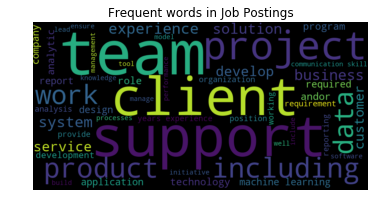

In [20]:
from wordcloud import WordCloud
# Create the wordcloud object
wordcloud_postings= WordCloud(width=1000, height=500, max_words=50).generate(text_cloud)
# Display the generated image:
c=plt.imshow(wordcloud_postings, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Frequent words in Job Postings')
plt.show()

# Principal Component Analysis and filtering out unimportant words
To filter out the useless words, Principal Component Analysis has been used. Each principal component is a linear combination of features (uni-grams and bi-grams in this case). For the first 20 principal components, the following part of the code pick the features having the positive highest and negative lowest coefficients in each principal component. In plain language, these features have caused the highest variance in our dataset which means they carry more information in our dataset compared to other features.

In [21]:
# Vectorizing the job postings into features and TF-IDF measure of each feature in each job posting
U=TfidfVectorizer(ngram_range=(1,2)) 
P=U.fit_transform(postings['job_description'])
tfidf=P.toarray(order=None, out=None)
tfidf_df=pd.DataFrame(tfidf)
# To store all the uni-grams and bi-grams in a list
Vocabulary=U.get_feature_names()

In [22]:
len(Vocabulary)

316252

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20, random_state=3)  
X_train = pca.fit_transform(tfidf_df) # to obtain the first 20 principal components
                                      # (why 20? because the results were better using 20 principal components!

In [24]:
important_indices=[]
for i in range(20):
    indices=np.argsort(pca.components_[i])
    important_indices.append(indices[0:200])#to get the index of the features having positive highest coefficeint in each principal component 
    important_indices.append(indices[-200:])#to get the index of the features having negative lowest coefficeint in each principal component

In [25]:
imp_features=[]
for i in important_indices:
    for j in i:
        imp_features.append(Vocabulary[j]) # to get the words in the vocabulary using indices from previous cell

In [26]:
imp_features

['data',
 'business',
 'experience',
 'analytics',
 'management',
 'work',
 'skills',
 'support',
 'team',
 'reporting',
 'analysis',
 'financial',
 'marketing',
 'development',
 'ability',
 'insights',
 'including',
 'project',
 'analytical',
 'knowledge',
 'customer',
 'role',
 'working',
 'provide',
 'strong',
 'process',
 'technical',
 'key',
 'quality',
 'tools',
 'environment',
 'product',
 'sales',
 'risk',
 'software',
 'teams',
 'design',
 'develop',
 'systems',
 'help',
 'reports',
 'planning',
 'advanced',
 'customers',
 'opportunities',
 'people',
 'strategic',
 'projects',
 'create',
 'lead',
 'stakeholders',
 'digital',
 'required',
 'analyst',
 'requirements',
 'asset',
 'performance',
 'deliver',
 'health',
 'understanding',
 'internal',
 'years',
 'finance',
 'cell',
 'strategy',
 'excellent',
 'degree',
 'media',
 'opportunity',
 'ensure',
 'responsible',
 'building',
 'manage',
 'position',
 'bi',
 'multiple',
 'apply',
 'organization',
 'complex',
 'job',
 'operatio

In [27]:
len(list(set(imp_features)))

3309

As it is shown above, although the n-grams are more relevant to data science, there are a lot of n-grams that are not. Using these words as the vocabulary series in another TF-IDF vectorizer, another TF-IDF matrix has been calculated and another Principal Component Analysis has been conducted. In the principal component analysis in this stage, the top 100 most important features in each first twenty principal componet have been obtained (features having positive highest and negative lowest coefficients in each principal component). The result is presented bellow: (It was so interesting!!!!!)

In [28]:
U1=TfidfVectorizer(ngram_range=(1,2), vocabulary=list(set(imp_features)))#defining a vectorizer using the vocabulary from previous line
P1=U1.fit_transform(postings['job_description'])
tfidf1=P1.toarray(order=None, out=None)
tfidf_df1=pd.DataFrame(tfidf1)
Vocabulary=U1.get_feature_names() 


pca = PCA(n_components=20, random_state=3) #Conducting another PCA to further decrease the number of n-grams in the vocabulary
X_train = pca.fit_transform(tfidf_df1)

important_indices=[]
for i in range(20):
    indices=np.argsort(pca.components_[i])
    important_indices.append(indices[0:50])#to get the index of the features having positive highest coefficeints in each principal component 
    important_indices.append(indices[-50:])#to get the index of the features having negative lowest coefficeints in each principal component 
    
imp_features=[]
for i in important_indices:
    for j in i:
        imp_features.append(Vocabulary[j]) # to get the words in the vocabulary using indices from previous lines

In [29]:
len(list(set(imp_features)))

676

In [30]:
imp_features

['data',
 'learning',
 'machine',
 'machine learning',
 'business',
 'experience',
 'analytics',
 'data science',
 'models',
 'insights',
 'science',
 'big',
 'tools',
 'python',
 'big data',
 'sql',
 'statistics',
 'algorithms',
 'solutions',
 'statistical',
 'data scientist',
 'analysis',
 'build',
 'ai',
 'team',
 'spark',
 'intelligence',
 'software',
 'problems',
 'predictive',
 'visualization',
 'large',
 'modeling',
 'computer science',
 'design',
 'bi',
 'techniques',
 'programming',
 'youll',
 'help',
 'data scientists',
 'cloud',
 'complex',
 'building',
 'model',
 'teams',
 'working',
 'sources',
 'sets',
 'data analytics',
 'health safety',
 'resume',
 'reclamation',
 'activities',
 'groundwater',
 'project',
 'cannabis',
 'stemcell',
 'maxxam',
 'lab',
 'scientific',
 'position',
 'quality',
 'chemistry',
 'de la',
 'une',
 'health',
 'regulatory',
 'soil',
 'samples',
 'au',
 'required',
 'assessments',
 'staff',
 'field',
 'du',
 'water',
 'duties',
 'donnes',
 'assessme

As it is shown, now we have a list of 676 unique uni-grams and bi-grams very related to data science. To explain what happened in a nutshell: **Out of 316252 uni-grams and bi-grams in the job postings, using two Principal Component Analysis, 676 of them were selected which are highly related to data science domain.** (which are shown above)

# Filtering out the irrelevant terms using irrelevant materials to data science 
We could continue our investigation in job postings using these 676 uni-grams and bi-grams but we decided to further narrow them down. The idea was to gather a list of completely irrelevant uni-grams and bi-grams to data science and filter them out. (similar to stopwords)

In order to do so, we used airline tweets, some New York Times articels and job postings looking for chef or musician (which are normlly irrelevant to data science) as irrelevant materials. 

To make sure that we would not miss any relevant word, we defined a list of highly relevant words to data science and filtered out the materials containing one or more of these words. **(This list of highly related words to data science was obtained using the kaggle 2018 survey)**

In [31]:
skills= pd.read_csv('skills_csv_dictionary.csv', encoding= 'utf-8') #reading the defined dictionary of relevant words
skills.head()

,Excel
0,Excel
1,Microsoft Excel
2,SAS
3,Google Sheets
4,SPSS


In [32]:
# Cleaning the words
skills_str=''
for i in range(0,len(skills)):
    text=skills['Excel'][i]
    #Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
    #All html tags and attributes (i.e., /<[^>]+>/) are removed.
    clean_text=BeautifulSoup(text).get_text()
    clean_text=clean_text.replace('\n', ' ')             #to replace lines in tweets with space
    clean_text=re.sub(r'[^a-zA-Z ]','',clean_text)     #to remove html tags (it also removes the numbers,punctuations and symbols except)
    clean_text=clean_text.lower()     #characters is lower-case 
    skills['Excel'][i]=clean_text
    skills_str=skills_str+'??'+clean_text
skills_list=skills_str.split('??')
del skills_list[0]

In [33]:
# Reading the irrelevant materials

# Reading some irrelevant tweets (from assignment1)
airline_vocabulary=open('airline_vocabulary.txt','r').read()
list_airline_vocabulary=airline_vocabulary.split('//')
# Reading some irrelevant New York Times Articles (from our group presentation)
irrelevent_articles= pd.read_csv('Articles_Sorted_Text_irr.csv', encoding= 'utf-8', usecols = ['date','url','word_count','article_text'])
# Reading some irrelevant job postings (which are scraped from Indeed web service)
postings_irr= pd.read_csv('Job_Skills_irr.csv', encoding= 'utf-8', usecols=['job_title', 'company_name', 'job_description'])
irrelevent_articles=irrelevent_articles.dropna(subset=['article_text'])
postings_irr=postings_irr.dropna(subset=['job_description'])

In [34]:
irrelevent_articles.head()

,date,url,word_count,article_text
0,1/1/2010,https://query.nytimes.com/gst/fullpage.html?re...,352,\r\r\n ...
1,1/1/2010,https://www.nytimes.com/2010/01/01/education/0...,1186,"COMMACK, N.Y. — There have been so many honor..."
2,1/3/2010,https://www.nytimes.com/2010/01/03/arts/televi...,1435,THE decade opened with an alpha male in a psy...
3,1/3/2010,https://www.nytimes.com/2010/01/03/arts/design...,1166,PACKAGING art by the decade isn't realistic; ...
4,1/3/2010,https://www.nytimes.com/2010/01/03/education/e...,678,"SOME things never change. For example, childr..."


The following part of the code cleans the irrelevant materials as follows: 

In [35]:
pd.options.mode.chained_assignment = None

irrelevent_articles.reset_index(inplace=True, drop=True)
for i in range(len(irrelevent_articles)):
    text=irrelevent_articles['article_text'][i]
    #Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
    #All html tags and attributes (i.e., /<[^>]+>/) are removed.
    clean_text=BeautifulSoup(text).get_text()
    clean_text=clean_text.replace('\n', ' ')             #to replace lines with space
    clean_text=re.sub(r'https?://[A-Za-z0-9./]+','',clean_text)         #to remove urls
    clean_text=re.sub(r'www\.[A-Za-z0-9./~]+','',clean_text)            #to remove urls
    clean_text=re.sub(r'[^a-zA-Z ]','',clean_text)     #to remove html tags (it also removes the numbers,punctuations and symbols except)
    clean_text=clean_text.lower()     #characters is lower-case 
    irrelevent_articles['article_text'][i]=clean_text
list_irrelevent_articles=list(irrelevent_articles['article_text'])




for i in range(0,len(postings_irr)):
    text=postings_irr['job_description'][i]
    #Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
    #All html tags and attributes (i.e., /<[^>]+>/) are removed.
    clean_text=BeautifulSoup(text).get_text()
    clean_text=clean_text.replace('\n', ' ')             #to replace lines with space
    clean_text=re.sub(r'https?://[A-Za-z0-9./]+','',clean_text)         #to remove urls
    clean_text=re.sub(r'www\.[A-Za-z0-9./~]+','',clean_text)            #to remove urls
    clean_text=re.sub(r'[^a-zA-Z ]','',clean_text)     #to remove html tags (it also removes the numbers,punctuations and symbols except)
    clean_text=clean_text.lower()     #characters is lower-case 
    tokenized_tweet=word_tokenize(clean_text)
    clean_text=[t for t in tokenized_tweet if not t in Stop_Words1]
    s=' '
    postings_irr['job_description'][i]=s.join(clean_text)
list_irrelevent_postings=list(postings_irr['job_description'])

The following part of the code remove all the irrelevant materials which can be potentially related to data science (using a relevant dictionay of the most popular words realted to data science.)

Conservatively, the code has been written in a way to remove the material as a whole if it contains even one related word to data science. 

In [36]:
article_temp =[] # to store irrelevant NYT articles to data science
for j in skills_list: # j is a popular word related to data science
    for i in range(len(list_irrelevent_articles)): # i is a potentially irrelevant material to data science
        if j in list_irrelevent_articles[i]:
            article_temp.append(list_irrelevent_articles[i])
    list_irrelevent_articles= list(set(list_irrelevent_articles)-set(article_temp))


posting_temp =[]  #to store irrelevant job postings to data science
for j in skills_list:
    for i in range(len(postings_irr)):
        if j in postings_irr['job_description'][i]:
            posting_temp.append(postings_irr['job_description'][i])
    list_irrelevent_postings= list(set(list_irrelevent_postings)-set(posting_temp))

    
irrelevant_mat=list_irrelevent_postings+list_irrelevent_articles+list_airline_vocabulary # to put together all the irrelevant materials

In [37]:
len(irrelevant_mat)

65807

In order to be able to filter out the irrelevant words, first using **get_feature_names()** method of tf-idf vectorizer, all the unique uni-grams and bi-grams of irrelevant materials were obtained. Using these irrelevant uni-grams and bi-grams, the important features obtained from principal component analysis are filtered as follows:

In [38]:
U_irr=TfidfVectorizer(ngram_range=(1,2)) #to vectorize the irrelevant materials into uni-grams and bi-grams
P_irr=U_irr.fit_transform(irrelevant_mat)
Vocabulary_irr=U_irr.get_feature_names() #to store the irrelevant uni-grams and bi-grams

In [39]:
len(Vocabulary_irr) # the number of irrelevant uni-grams and bi-grams

130125

The following line filters out the irrelevant uni-grams and bi-grams.

In [40]:
Vocabulary1=[word for word in imp_features if word not in Vocabulary_irr]

In [41]:
Vocabulary1

['machine learning',
 'data science',
 'python',
 'big data',
 'sql',
 'algorithms',
 'statistical',
 'data scientist',
 'ai',
 'predictive',
 'visualization',
 'modeling',
 'computer science',
 'bi',
 'data scientists',
 'data analytics',
 'reclamation',
 'groundwater',
 'cannabis',
 'stemcell',
 'maxxam',
 'assessments',
 'donnes',
 'remediation',
 'finance',
 'excel',
 'tensorflow',
 'artificial intelligence',
 'data scientists',
 'computer science',
 'big data',
 'data scientist',
 'deep learning',
 'donnes',
 'data science',
 'python',
 'algorithms',
 'ai',
 'machine learning',
 'machine learning',
 'ai',
 'remediation',
 'algorithms',
 'assessments',
 'deep learning',
 'assays',
 'reclamation',
 'sql',
 'donnes',
 'business intelligence',
 'bi',
 'stakeholders',
 'finance',
 'bi',
 'finance',
 'business intelligence',
 'sql',
 'statistical',
 'assessments',
 'remediation',
 'data analytics',
 'marketing campaigns',
 'marketing team',
 'content marketing',
 'conversion',
 'email m

In [42]:
final_vocablary=list(set(Vocabulary1))

In [43]:
len(final_vocablary)

229

The result above was one of the most interesting part of this investigation. As it is shown, there are 229 unique uni-grams and bi-grams almost all of which are realated to data science field. Now this series can be used to analyze the job postings to get insight for designing the curriculum and the programs from a high-level perspective. 

First, the series of uni-grams and bi-grams above has been used as a parameter in **CountVectorizer()** function to generate a matrix of word-counts using which the job postings have been clustered into two clusters using K-Means clustering.

In [44]:
U_final=CountVectorizer(ngram_range=(1,2), vocabulary=final_vocablary)#defining a vectorizer using the final vocabulary from previous part
P_final=U_final.fit_transform(postings['job_description'])
wordcount_final=P_final.toarray(order=None, out=None)
wordcount_final_df=pd.DataFrame(wordcount_final)
Vocabulary_final=U_final.get_feature_names()

# Clustering the job postings into two clusters

As it was mentioned, it was assumed that the required skill-set of business oriented job postings are generally different from the required skill-set in technical oriented job postings. In this case, a skill-set can be described as a vector of uni-grams and bi-grams in each job posting.
With this in mind, using K-Means clustering, the job postigs have been clusterd into two clusters based on one of which the high-level themes of technical oriented program have been obtained and based on the other, the high-level themes of businees oriented have been obtained. 

In [45]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=4) # to cluster the job postings into two clusters
kmeans.fit(wordcount_final_df)

centroids = kmeans.cluster_centers_ 
labels = kmeans.labels_ # to get the labels of samples (0 for cluster one and 1 for cluster two)

print(labels)

[1 0 0 ... 1 0 1]


In [46]:
wordcount_final_df.columns=Vocabulary_final
wordcount_final_df['Label']=pd.DataFrame(labels)

In [47]:
Clusters_top40_words=[] # to get the 40 top most frequent words in each cluster
for cluster in range(2):
    Clusters_top40_words.append(wordcount_final_df[wordcount_final_df['Label']==cluster].sum().nlargest(40))

In [48]:
# for i in Clusters_top40_words:
#     if 'Label' in i.index:
#         del i['Label']
#     print (i,' \n')

machine learning           718
ai                         357
data science               266
algorithms                 238
python                     235
donnes                     204
big data                   172
statistical                143
computer science           135
modeling                   132
data scientist             130
predictive                 114
deep learning              113
sql                        110
artificial intelligence    110
data scientists            108
data mining                 81
stakeholders                80
agile                       72
scalable                    71
data analysis               68
quantitative                68
azure                       66
data analytics              62
learning models             60
aws                         58
visualization               57
implementation              57
tensorflow                  56
software development        51
learning algorithms         49
pipelines                   45
demonstr

In [49]:
Counter(labels)

Counter({1: 1459, 0: 203})

The results above show the top 40 most frequent words in each cluster. Interestingly enough, the second cluster's most frequent words are much more businees oriented compared to the first cluster. In order to more clearly explain the conclusion, the following part generates a bar plot for each cluster:

In [50]:
percentage_cluster1=np.round_(np.array(Clusters_top40_words[0].values)/1662*100)

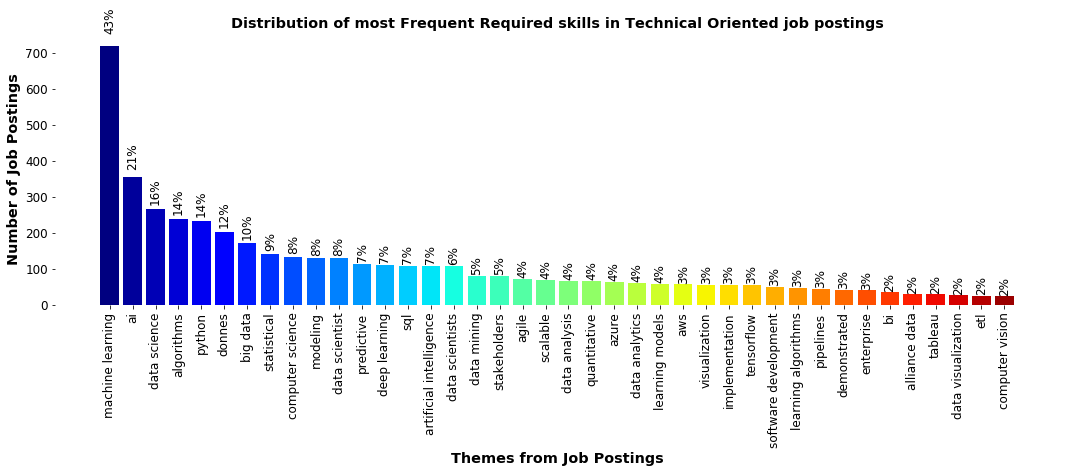

In [51]:
# f, ax = plt.subplots(figsize=(18,5))
# bar=plt.bar(Clusters_top40_words[0].index, Clusters_top40_words[0].values ,align='center',color=[cm.jet(1.*e/len(Clusters_top40_words[0].index)) for e in range(len(Clusters_top40_words[0].index))])
# plt.xticks(rotation=90)
# plt.ylabel("Number of Job Postings",fontweight='bold', fontsize='x-large')
# plt.xlabel("Themes from Job Postings",fontweight='bold', fontsize='x-large')
# plt.title("Distribution of most Frequent Required skills in Technical Oriented job postings",fontweight='bold', fontsize='x-large')
# plt.xticks(rotation=90, fontsize='large')
# plt.yticks(fontsize='large')

# def autolabel(rects):
#     """
#     Attach a text label above each bar displaying its height
#     """
#     for i in range(len(rects)):
#         rect=rects[i]
#         height = rect.get_height()
#         ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
#                  str(int(percentage_cluster1[i])) + '%',
#                 ha='center', va='bottom', rotation=90, fontsize='large')

# autolabel(bar)
# plt.box(on=None)
# plt.savefig('technical.jpg', dpi=300, transparent=True , bbox_inches='tight')
# plt.show()

In [52]:
# percentage_cluster2=np.round_(np.array(Clusters_top40_words[1].values)/1662*100)

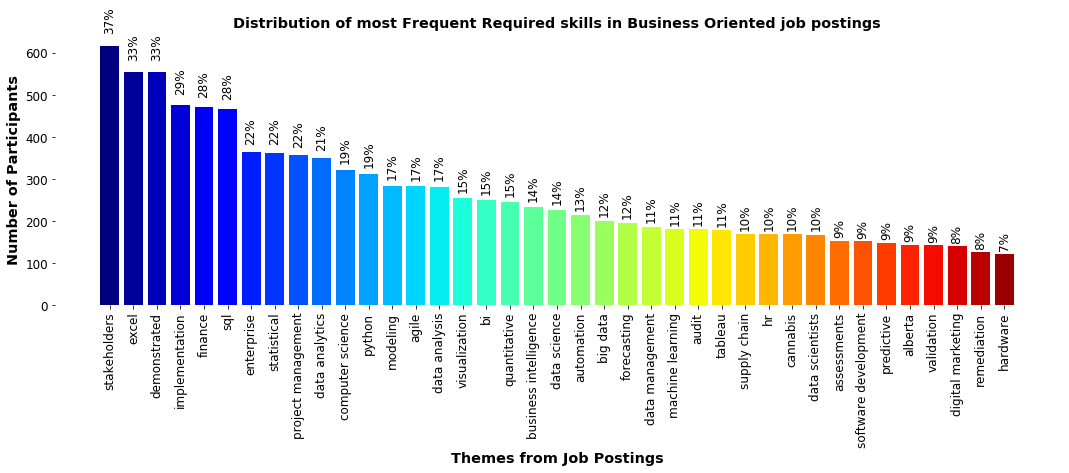

In [53]:
# f, ax = plt.subplots(figsize=(18,5))
# bar=plt.bar(Clusters_top40_words[1].index, Clusters_top40_words[1].values ,align='center',color=[cm.jet(1.*e/len(Clusters_top40_words[1].index)) for e in range(len(Clusters_top40_words[1].index))])
# plt.xticks(rotation=90)
# plt.ylabel("Number of Participants",fontweight='bold', fontsize='x-large')
# plt.xlabel("Themes from Job Postings",fontweight='bold', fontsize='x-large')
# plt.title("Distribution of most Frequent Required skills in Business Oriented job postings",fontweight='bold', fontsize='x-large')
# plt.xticks(rotation=90, fontsize='large')
# plt.yticks(fontsize='large')

# def autolabel(rects):
#     """
#     Attach a text label above each bar displaying its height
#     """
#     for i in range(len(rects)):
#         rect=rects[i]
#         height = rect.get_height()
#         ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
#                  str(int(percentage_cluster2[i])) + '%',
#                 ha='center', va='bottom', rotation=90, fontsize='large')

# autolabel(bar)
# plt.box(on=None)
# plt.savefig('business.jpg', dpi=300, transparent=True , bbox_inches='tight')
# plt.show()

By comparing the clusters to each other, it can be realized that the first cluster is more technical oriented than the second cluster. For instance, the most frequent word in the technical oriented cluster is **Machine Learning** and the most frequent word in the business oriented cluster is **Stakeholders**. Also some words such as **Finance, enterprise, supply chain, HR(Human Resource), Project Management, Business Intelligence, Automation and Digital Marketing** can be found in the business oriented cluster and not in the technical oriented cluster. Another interesting result that can be inferred from these barplots is that in the more technical oriented job postings, **Python** is more important than **SQL** and vice versa because the frequency of **Python** is more than **SQL** but in the other cluster the frequency of **SQL** is more than **Python**. The results from these parts helped us to prioritize each programing language in each program and also to design the themes for each master's program.

In [54]:
# wordcount_final_df=wordcount_final_df.drop(labels='Label', axis=1)
# most_frequent_words = wordcount_final_df.sum().nlargest(40)
# most_frequent_words

machine learning           899
stakeholders               696
demonstrated               597
sql                        577
excel                      564
python                     547
implementation             534
statistical                506
data science               493
finance                    486
ai                         471
computer science           457
modeling                   417
data analytics             412
enterprise                 406
project management         381
big data                   373
algorithms                 358
agile                      355
data analysis              350
quantitative               314
visualization              312
bi                         286
data scientists            276
donnes                     262
predictive                 262
business intelligence      242
automation                 233
forecasting                217
data scientist             217
tableau                    209
data management            208
software

In [55]:
# percentage= np.round_(np.array(most_frequent_words.values)/1662*100)

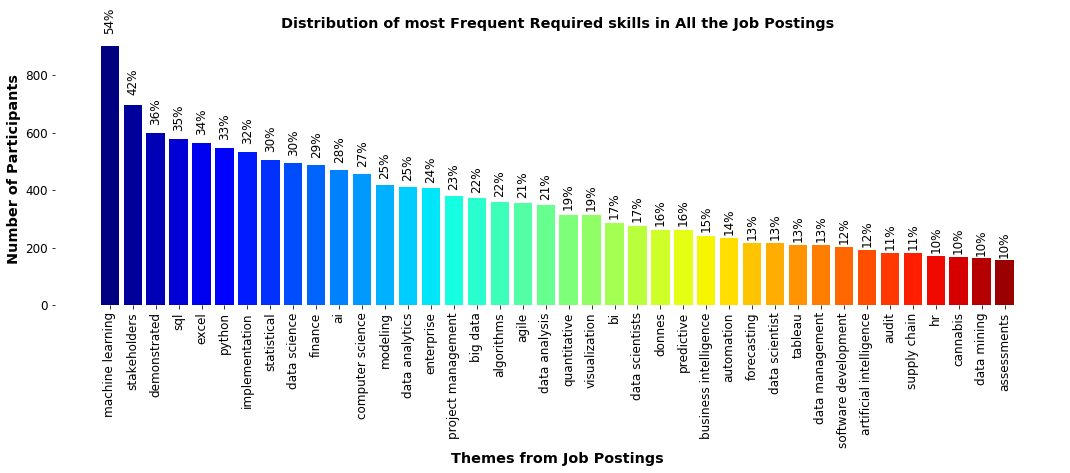

In [56]:
# f, ax = plt.subplots(figsize=(18,5))
# bar=plt.bar(most_frequent_words.index, most_frequent_words.values ,align='center',color=[cm.jet(1.*e/len(most_frequent_words.index)) for e in range(len(most_frequent_words.index))])
# plt.xticks(rotation=90)
# plt.ylabel("Number of Participants",fontweight='bold', fontsize='x-large')
# plt.xlabel("Themes from Job Postings",fontweight='bold', fontsize='x-large')
# plt.title("Distribution of most Frequent Required skills in All the Job Postings",fontweight='bold', fontsize='x-large')
# plt.xticks(rotation=90, fontsize='large')
# plt.yticks(fontsize='large')

# def autolabel(rects):
#     """
#     Attach a text label above each bar displaying its height
#     """
#     for i in range(len(rects)):
#         rect=rects[i]
#         height = rect.get_height()
#         ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
#                  str(int(percentage[i])) + '%',
#                 ha='center', va='bottom', rotation=90, fontsize='large')

# autolabel(bar)
# plt.box(on=None)
# plt.savefig('all.jpg', dpi=300, transparent=True , bbox_inches='tight')
# plt.show()

The barplot above shows the 40 top most frequent words in all the job postings combined. This barplot was used to design the themes of the curriculum of the introduction to data science course. 

The process of designing the curriculum and the programs in detail involved a lot of subjectivity, discussion and research in other programs and tracking different trends in the web. The designing process of each of them was not a linear sequential process rather it was an abstract thinking and brainstorming which would culminate in a decision. 

For example, by looking at our results from job postings and the kaggle survey from assignment1, we decided that **Cloud Computing** is a very important concept that should be covered in our programs. But in order to decide which cloud computing platforms to use in each program, we manually defined a dictionary of all the popular cloud computing platforms which was used to search through the job postings to obtain the number of job postings containing each cloud computing platform. Next, a binary matrix of occurance or not-occurance of the words in the dictionary were generated. Afterwards, the frequency of each cloud computing platform in the job postings were used as a measure to decide which platform to use. Also to differentiate the cloud computing platforms covered in technical oriented program from business oriented program, the words **Finance** and **Marketing** were added to the cloud computing dictionary to enable us to clearly seperate the business oriented job postings from technical oriented job postings using K-Means clustering. It was done by applying the **KMeans()** function to the binary matrix of occurance or not-occurance of the words in the manually defined dictionary which was mapped to the job postings. The result was that in both technical oriented and business oriented job postings, **AWS and Azure** platforms were more important, so we covered both in both programs. 

The Same approach was done to decide:

1. What programming languages to cover in each program? For business oriented main focous should be on R and SQl and for the technical oriented program the main focous should be on Python.

2. What big data frameworks to cover in each program? Spark, Hadoop and Hive should be covered in both programs.
 
3. What cloud computing platform to cover in each program? AWS and Azure should be covered in both programs. 

4. What deep learning frameworks to cover in each program? PyTorch and Keras should be covered in both programs. 

and so on and so forth ...

The following parts of the code carry out these tasks:


In [57]:
dfSkill = pd.read_csv("Job_Skills.csv", low_memory = False) #To store the job postings in a new dataframe for a different analysis

In [58]:
# in this part the cleaning of the job postings has been conducted.  
def clean_text(text):
    # (1) Replacing html character codes with ASCII equivalent
    soup = BeautifulSoup(text, 'lxml')
    html_converted_to_ASCII = soup.get_text()
    try:
        # (2)Clean article replacing unicode characters.
        unicode_cleaned = html_converted_to_ASCII.decode("utf-8-sig").replace(u"\ufffd", "?").replace(u'\u2018', u"'").replace(u'\u2019', u"'").replace(u'\u201c', u'"').replace(u'\u201d', u'"')
    except:
        unicode_cleaned = html_converted_to_ASCII

    # (3) Remove URLs 
    nourl_result = re.sub(r'https?://[A-Za-z0-9./]+', "", unicode_cleaned)
    # (4) Remove websites 
    noweb_result = re.sub(r'www.[^ ]+', '', nourl_result)
    # (5) Remove Hash tags 
    nohashtag_result = re.sub(r"(?:\#+)",'', noweb_result)
    # (6) Remove mentions 
    nomentions_result = re.sub(r'(?:@[\w_]+)', '', nohashtag_result)
    # (8) Conver all letters to lower case
    lower_case = nomentions_result.lower()
    
    # (10) Remove html tags and attributes and only keep the words
    letters_only = re.sub("[^a-zA-Z]", " ", lower_case)

    letters_only= re.sub(' +', ' ', letters_only)
    
    return (letters_only)

def clean_job_postings(dfSkill):
    job_html_text=dfSkill['job_description']

    for i in range(0,len(job_html_text)):
        job_html_text[i]=clean_text(job_html_text[i])
        
    dfSkill['cleaned_description']=job_html_text

In [59]:
# to clean the job postings using the functions written above
clean_job_postings(dfSkill)

In [60]:
dfSkill.to_csv('Job_Skills_Cleaned.csv',encoding='utf-8') # to save the cleaned job postings to avoid cleaning them again

In [61]:
dfSkill = pd.read_csv('Job_Skills_Cleaned.csv')# to read the cleaned job postings which was save in the previous line

In order to search through the job postings using a manually defined dictionary to make specific decisions, the following function has been defined to create a binary matrix of occurance and not-occurance of the words of the manually defined dictionary mapped to the job postings. This approach enabled us to iteratively change the dictionary and generate different binary matrices using which we decided which tools, platfroms, coding languages, bigdata frameworks, etc to cover in each program.

In [62]:
def skill_count(dfSkill,skills_keywords_dict):
    df = pd.DataFrame()
    df['cleaned_description']=dfSkill['cleaned_description']
    for item in skills_keywords_dict:
        df[item]=0
        
    for i in range(0,len(df)):
        for j in range(1,len(df.columns)):
            values = skills_keywords_dict[df.columns[j]]
            for value in values:
                if (value.lower() in df.iloc[i,0]):
                    df.iloc[i,j] = 1
                    
    return df

The following dictionary was used to decide which coding languages to cover in each program. After generating the binary matrix of ocuurance and not-occurance, K-Means clustering algorithm has been used to seperate the technical oriented job postings from the business oreinted job postings. The words **Finance & Marketing** have been added to this dictionary to allow us identify each type of cluster (if these words were more frequented in one cluster, based on our previous analyses, we could conclude that cluster is more business oriented.)

In [63]:
CodingLanguages_dict={
                        
                            'Python': ['Python'],
                            'R': [' R '], # 'R' surrounded by spaces and signs
                            'Ruby': ['Ruby'],
                            'Java/Scala': ['Java', 'JVM', 'Scala', 'Javascript'],
                            'C/C++': ['C/C++', 'C++', ' C '],   # 'C' surrounded by spaces and signs
                            'MATLAB': ['MATLAB'],
                            'SAS': ['SAS'],
                            'SQL':['SQL'],
                            'Visual Basic':['Visual Basic'],
                            'html':['html'],
                            'Finance':['Finance'],
                            'Marketing':['Marketing'],                        
            
                   }

In [64]:
#to generate the binary matrix of occurance and not-occurance based on coding languages
skill_count_df= skill_count(dfSkill,CodingLanguages_dict)
skill_count_df=skill_count_df.drop('cleaned_description', axis=1)
skill_count_df.head()

,Python,R,Ruby,Java/Scala,C/C++,MATLAB,SAS,SQL,Visual Basic,html,Finance,Marketing
0,1,1,0,0,0,0,1,1,0,0,0,0
1,1,1,0,0,0,0,1,1,0,0,0,1
2,1,0,0,1,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,0,0


In [65]:
# to cluster the job postings into two clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=3)
kmeans.fit(skill_count_df)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(labels)

[1 1 1 ... 1 1 0]


In [66]:
skill_count_df['Label']=pd.DataFrame(labels)

The following part of the code finds and prints out the top 10 most frequent words of each cluster based on the predefined dictionary of the coding languages. 

In [67]:
#finding and printing the frequent coding languages in each cluster
Clusters_top10_words=[]
for cluster in range(2):
    Clusters_top10_words.append(skill_count_df[skill_count_df['Label']==cluster].sum().nlargest(10))

In [68]:
# Clusters_top10_words

[Marketing     269
 Finance       196
 R             155
 SQL           123
 SAS           120
 Java/Scala    113
 C/C++          92
 html           42
 Python         22
 MATLAB          6
 dtype: int64, Label         524
 Python        433
 SQL           350
 R             283
 Java/Scala    257
 C/C++         164
 Marketing     124
 SAS           117
 Finance        67
 MATLAB         43
 dtype: int64]

As it is shown, in the first cluster the words **Marketing and Finance** are more frequnet than the second cluster, so the first cluster represents the more business oriented cluster of job postings. In this cluster, **R, SQL and SAS** are more frequent than other coding languages, so these coding languages were chosen to be covered in the business oriented program. In the other cluster which represents the more technical oriented program, **Python and SQL** are more frequent than other coding languages, so they were chosen to be covered in the technical oriented program. **(after conducting another analysis using the Kaggle 2018 survey and our dataset of job postings, interestingly we found that although SCALA coding language is not as frequent as these coding languages, the salary of the people using SCALA as their primary coding language is considerably higher than other participants, so we covered this coding language in our technical oriented program as well. This analysis has been done seperately in the following parts of this Jupyter Notebook. The reason why we covered SCALA in the technical oriented program not the other program is that this coding language is used mostly in a technical oriented space to develop the software.)**

Similarly, the following part of the code uses the same method to allow us to decide which BigData tools to cover in each program.

In [69]:
# to define a dictionary of big data tools (plus the words marketing and finance for the abovementioned reason)
BigData_dict={
                            'Google BigQuery': ['Google BigQuery'],
                            'Spark':['Spark'],
                            'kafka':['kafka'],
                            'Hive':['Hive'],
                            'beam':['beam'],
                            'Hadoop':['Hadoop'],
                            'MapReduce':['MapReduce'],
                            'Hbase':['Hbase'],
                            'MangoDB':['MangoDB'],
                            'Cassandra':['Cassandra'],
                            'Neo4':['Neo4'],
                            'HDFS':['HDFS'],
                            'Finance':['Finance'],
                            'Marketing':['Marketing'],
              
                   }

In [70]:
#to generate the binary matrix of occurance and not-occurance based on coding languages
skill_count_df= skill_count(dfSkill,BigData_dict)
skill_count_df=skill_count_df.drop('cleaned_description', axis=1)
skill_count_df.head()

,Google BigQuery,Spark,kafka,Hive,beam,Hadoop,MapReduce,Hbase,MangoDB,Cassandra,Neo4,HDFS,Finance,Marketing
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [71]:
kmeans = KMeans(n_clusters=2, random_state=3)
kmeans.fit(skill_count_df)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(labels)

[0 1 1 ... 0 0 0]


In [72]:
skill_count_df['Label']=pd.DataFrame(labels)

The following part of the code finds and prints out the top 10 most frequent words of each cluster based on the predefined dictionary of the big data tools.

In [73]:
Clusters_top10_words=[]
for cluster in range(2):
    Clusters_top10_words.append(skill_count_df[skill_count_df['Label']==cluster].sum().nlargest(10))

In [74]:
Clusters_top10_words

[Finance      188
 Spark        118
 Hadoop       110
 Hive          65
 kafka         41
 Cassandra     21
 Hbase         18
 HDFS          13
 MapReduce      8
 beam           3
 dtype: int64, Marketing          393
 Label              393
 Finance             75
 Spark               39
 Hadoop              26
 Hive                19
 kafka                8
 MapReduce            6
 Google BigQuery      3
 beam                 3
 dtype: int64]

As it is shown, both clusters contain business-representative terms. These clusters are telling us:
1. Big data tools are used more frequetly in the Finance industry compared to Marketing industry. (because the number of times these words has occured with the word **Finance** is greater than that of **Marketing**)
2. In both Marketing and Finance industries, **Spark, Hadoop and Hive** are more frequent than other bigdata tools.

Accordingly, we covered them in both of our programs. 

Similarly, the following part of the code has been adopted to decide about cloud computing platforms. 

In [75]:
# to define a dictionary of cloud computing tools
Cloud_dict={
                                                  
    
                            'AWS': ['AWS', 'Amazon Web Services'],
                            'EC2':['EC2'],
                            'Azure':['Azure', 'Microsoft Azure'],
                            'Google Cloud':['Google Cloud'],
                            'IBM Cloud':['IBM Cloud'],
                            'Kubernete':['Kubernete'],
                            'Lambda':['Lambda'],
                            'Alibaba Cloud':['Alibaba Cloud'],
                            'Finance':['Finance'],
                            'Marketing':['Marketing']

                   }

In [76]:
skill_count_df= skill_count(dfSkill,Cloud_dict)
skill_count_df=skill_count_df.drop('cleaned_description', axis=1)
skill_count_df.head()

,AWS,EC2,Azure,Google Cloud,IBM Cloud,Kubernete,Lambda,Alibaba Cloud,Finance,Marketing
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [77]:
kmeans = KMeans(n_clusters=2, random_state=3)
kmeans.fit(skill_count_df)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(labels)

[0 1 1 ... 0 0 0]


In [78]:
skill_count_df['Label']=pd.DataFrame(labels)

The following part of the code finds and prints out the top 10 most frequent words of each cluster based on the predefined dictionary of the cloud computing tools.

In [79]:
Clusters_top10_words=[]
for cluster in range(2):
    Clusters_top10_words.append(skill_count_df[skill_count_df['Label']==cluster].sum().nlargest(10))
Clusters_top10_words

[Finance          188
 AWS              136
 Azure             80
 Google Cloud      26
 Kubernete         22
 Lambda             3
 EC2                0
 IBM Cloud          0
 Alibaba Cloud      0
 Marketing          0
 dtype: int64, Marketing       393
 Label           393
 Finance          75
 AWS              47
 Azure             8
 Google Cloud      7
 Kubernete         1
 Lambda            1
 EC2               0
 IBM Cloud         0
 dtype: int64]

With a similar reasoning, we decided to cover **AWS and Azure** Cloud Computing platforms in our programs.

In [80]:
# to define a dictionary of deep learning tools
deeplearning_dict={
                                                  
    
                            'Tensor Flow': ['Tensor Flow'],
                            'Caffe':['Caffe'],
                            'Keras':['Keras'],
                            'Microsoft Cognitive Toolkit':['Microsoft Cognitive Toolkit'],
                            'IBM Watson':['IBM Watson'],
                            'DeepLearning4J':['DeepLearning4J'],
                            'PyTorch':['PyTorch'],
                            'Finance':['Finance'],
                            'Marketing':['Marketing']
              
                   }

In [81]:
skill_count_df= skill_count(dfSkill,deeplearning_dict)
skill_count_df=skill_count_df.drop('cleaned_description', axis=1)
skill_count_df.head()

,Tensor Flow,Caffe,Keras,Microsoft Cognitive Toolkit,IBM Watson,DeepLearning4J,PyTorch,Finance,Marketing
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0


In [82]:
kmeans = KMeans(n_clusters=2, random_state=3)
kmeans.fit(skill_count_df)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(labels)

[0 1 1 ... 0 0 0]


In [83]:
skill_count_df['Label']=pd.DataFrame(labels)

The following part of the code finds and prints out the top 10 most frequent words of each cluster based on the predefined dictionary of the deep learning tools.

In [84]:
Clusters_top10_words=[]
for cluster in range(2):
    Clusters_top10_words.append(skill_count_df[skill_count_df['Label']==cluster].sum().nlargest(10))
Clusters_top10_words

[Finance                        188
 PyTorch                         31
 Keras                           27
 Caffe                           15
 IBM Watson                       3
 Tensor Flow                      2
 Microsoft Cognitive Toolkit      0
 DeepLearning4J                   0
 Marketing                        0
 Label                            0
 dtype: int64, Marketing                      393
 Label                          393
 Finance                         75
 Keras                            5
 Caffe                            2
 PyTorch                          2
 IBM Watson                       1
 Tensor Flow                      0
 Microsoft Cognitive Toolkit      0
 DeepLearning4J                   0
 dtype: int64]

With a similar reasoning, we decided to cover **Pytorch, Keras and Caffe** in our programs. 

# ---------------------------------- Another Informative Analysis ----------------------------------


In [85]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import copy
from bs4 import BeautifulSoup
import re

import scipy.cluster.hierarchy as shc
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

## Define the comprehensive dictionary

In [86]:
# Reading the job skills csv files
dfSkill_DS_notClean = pd.read_csv("Job_Skills.csv", low_memory = False)

In [87]:
# Creating the skill and sub-skills dictionary
# Keys represen the skills
# Values are the sub-skills
# The skills include hard skills and soft skills
skills_keywords_dict = {
                            'Excel': ['Excel'],
                            'Python': ['Python'],
                            'R': [' R '], # 'R' surrounded by spaces and signs
                            'Ruby': ['Ruby'],
                            'Java/Scala': ['Java', 'JVM', 'Scala', 'Javascript'],
                            'C/C++': ['C/C++', 'C++', ' C '],   # 'C' surrounded by spaces and signs
                            'MATLAB': ['MATLAB'],
                            'Visual Studio':['Visual Studio'],
                            'SAS': ['SAS'],
                            'Databases': ['SQL', 'databases','NOSQL','Oracle'],
                            'SQL':['SQL'],
                            'etl':['etl'],
                            'Business Intelligence':['Business Intelligence'],
                            'Data Management':['Data Management'],
                            'SPSS': ['SPSS'],
                            'Stata': ['Stata'],
                            'RapidMiner': ['RapidMiner', 'Rapid Miner'],
                            'Machine Learning': ['Machine Learning', 'ML'],
                            'Data Mining/Analytics': ['Data Mining', 'Analytics', 'Data Analytics'],
                            'Artificial Intelligence':['artificial intelligence'],
                            'NLP': ['Natural Language Processing', 'NLP'],
                            'Computer vision':['computer vision', 'Visual recognition'],
                            'Image processing': ['image processing','image '] ,
                            'spark' : ['spark'],
                            'AWS':['AWS'],
                            'Azure':['Azure'],
                            'Agile':['Agile'],
    'Optimization':['Optimization'],
    
    'Simulation':['Simulation'],
    'Operation Research':['Operation Research'],
                            'Visualisation': ['Visualisation', 'Visualization','Power Point', 'Tableau'],
                            'Tableau':['Tableau'],
                            'Software':['Software development'],
                            'Big Data': ['Big Data', 'Spark', 'kafka', 'Hive', 
                                         'beam', 'Hadoop', 'MapReduce', 'Hbase','MangoDB','Cassandra','Neo4','HDFS',
                                        'Google Cloud Dataproc',
                                        'Google Cloud Dataflow',
                                        'Google Cloud Dataprep',
                                        'AWS Kinesis',
                                        'Google Cloud Pub/Sub',
                                        'AWS Athena',
                                        'AWS Redshift',
                                        'Google BigQuery',
                                        'Teradata',
                                        'Microsoft Analysis Services',
                                        'Oracle Exadata',
                                        'Oracle Warehouse Builder',
                                        'SAP IQ',
                                        'Snowflake',
                                        'Databricks',
                                        'Azure SQL Data Warehouse',
                                        'Azure HDInsight',
                                        'Azure Stream Analytics',
                                        'IBM InfoSphere DataStorage',
                                        'IBM Cloud Analytics Engine',
                                        'IBM Cloud Streaming Analytics',
                                        ],
                            'Oracle':['Oracle'],
                            'Google BigQuery':['Google BigQuery'],
    
                            'Cloud': ['Cloud', 'AWS','EC2', 'GCP', 'Azure ', 'Google Cloud'
                                                        'Amazon Web Services',
                                                        'Microsoft Azure',
                                                        'IBM Cloud',
                                                        'Alibaba Cloud',
                                      
                                                        'Google Compute Engine',
                                                        'AWS Elastic Beanstalk',
                                                        'Google App Engine',
                                                        'Kubernete',
                                                        'Lambda',
                                                        'Google Cloud Functions',
                                                        'AWS Batch',
                                                        'Azure Virtual Machines',
                                                        'Azure Container Service',
                                                        'Azure Functions',
                                                        'Azure Event Grid',
                                                        'Azure Batch',
                                                        'Azure Kubernetes Service',
                                                        'IBM Cloud Virtual Servers',
                                                        'IBM Cloud Container Registry',
                                                        'IBM Cloud Kubernetes Service',
                                                        'IBM Cloud Foundry'
                                                        ],
                            'Deep Learning':['Deep learning', 'Tensor Flow','Caffe','Keras','Microsoft Cognitive Toolkit','IBM Watson','DeepLearning4J'],
                            'Tensor Flow':['Tensor Flow','TensorFlow'],
                            'Keras':['Keras'],
                            'PyTorch':['PyTorch'],
    
                            'REST': [' REST ', 'flask', 'Sinatra'],
                            'SOAP':['SOAP'],
                            'Math': ['Algebra', 'Statistics', 'Operations research','Calculus' ],

                            'web scraping' : [ 'web scraping','web harvesting','web data extraction','web crawler','HTML','Soup'],
                            'Web development':['PHP','HTML','Ajax','ASP.NET',' ASP ','ColdFusion'],
                            'ASP':[' ASP '],
                            'HMTL':['HTML'],
                            
    
#                             'Marketing':['Marketing'],
#                             'Accounting':['Accounting'],
#                             'Exnterprise':['Exnterprise'],
#                             'Finance': ['Finance'],
#                             'Digital marketing':['Digital Marketing'],
#                             'Strategy':['Strategy','Strategic'],
                            
                            
#                             'integrated development environments':['Jupyter','Ipython',
#                                                                     'RStudio',
#                                                                     'PyCharm',
#                                                                     'Visual Studio Code',
#                                                                     'nteract',
#                                                                     'Atom',
#                                                                     'MATLAB',
#                                                                     'Visual Studio', 'VS'
#                                                                     'Notepad++',
#                                                                     'Sublime Text',
#                                                                     'Vim',
#                                                                     'IntelliJ',
#                                                                     'Spyder'
#                                                                     ],
                            
#                             'notebooks' :['Kaggle Kernels',
#                                             'Google Colab',
#                                             'Azure Notebook',
#                                             'Domino Datalab',
#                                             'Google Cloud Datalab',
#                                             'Paperspace',
#                                             'Floydhub',
#                                             'Crestle',
#                                             'JupyterHub','Binder'],

                            'machine learning framework' :['Scikit Learn','Scikit','scikit-learn',
                                        'TensorFlow',
                                        'Keras',
                                        'PyTorch',
                                        'Spark MLlib',
                                        'H20',
                                        'Fastai',
                                        'Mxnet',
                                        'Caret',
                                        'Xgboost',
                                        'mlr',
                                        'Prophet',
                                        'randomForest',
                                        'lightgbm',
                                        'catboost',
                                        'CNTK',
                                        'Caffe'
                                        ],
                            
    

                            
#                             'machine learning products':['Amazon Transcribe',
#                                         'Google Cloud Speech',
#                                         'Amazon Rekognition',
#                                         'Google Cloud Vision API',
#                                         'Amazon Comprehend',
#                                         'Google Cloud Natural Language API',
#                                         'Amazon Translate',
#                                         'Google Cloud Translation API',
#                                         'Amazon Lex',
#                                         'Google Dialogflow Enterprise Edition',
#                                         'Amazon Rekognition Video',
#                                         'Google Cloud Video Intelligence API',
#                                         'Google Cloud AutoML',
#                                         'Amazon SageMaker',
#                                         'Google Cloud Machine Learning Engine',
#                                         'DataRobot',
#                                         'H20 Driverless AI',
#                                         'Domino Datalab',
#                                         'SAS',
#                                         'Dataiku',
#                                         'RapidMiner',
#                                         'Instabase',
#                                         'Algorithmia',
#                                         'Dataversity',
#                                         'Cloudera',
#                                         'Azure Machine Learning Studio',
#                                         'Azure Machine Learning Workbench',
#                                         'Azure Cortana Intelligence Suite',
#                                         'Azure Bing Speech API',
#                                         'Azure Speaker Recognition API',
#                                         'Azure Computer Vision API',
#                                         'Azure Face API',
#                                         'Azure Video API',
#                                         'IBM Watson Studio',
#                                         'IBM Watson Knowledge Catalog',
#                                         'IBM Watson Assistant',
#                                         'IBM Watson Discovery',
#                                         'IBM Watson Text to Speech',
#                                         'IBM Watson Visual Recognition',
#                                         'IBM Watson Machine Learning',
#                                         'Azure Cognitive Services'       
#                                 ],
                                
                                # soft skills
#                             'communication': ['communication', 'presentation','power point'],
#                             'problem solving': ['problem solving'],
#                             'project_management': ['project management'],
#                             'leadership': ['leadership'],
#                             'consulting': ['consulting'],
                            
                        
                            # soft skills
    
                            'communication skills':['communication','ability to explain','explaination','negotiation','speaking','listening','relationship','open to feedback','receptiveness to feedback','body language','presentation'],
                            'organizational and management skills':['organizational skills', 'project management', 'management skills','self management','keeping deadline','delegation','time management','conflict management','decision making','leadership','coaching','mentoring'],
                            'professional skills':['professional skills','consult','consulting','consultation','documenting','storytelling','reporting','visualization','manipulating','experimentation','professionalism'],
                            'interpersonal skills':['interpersonal skills','self confidence','confidence','respectfulness','dependability','gesture','appreciation','showing positivity','creativity','commitment','accountability','change ready','innovation','innovative thinking','friendliness','adaptability','courtesy','flexibility','integrity','adaptable','creative','Creativity'],
                            'work place skills':['teamwork','team working','team work','ethic','collaboration','managing stakeholder expectations','problem solving','independently','multitasking','multitask','ad-hoc analysis','fast delivery','workplace etiquette']
                        }


## Removing the duplicates and clean the text of the jobs' description

In [88]:
def parse_job_info(dfSkill, skills_keywords_dict):

  # search for the skills
        soup_job = BeautifulSoup(job_html_text, 'lxml')
        soup_job_text = soup_job.text
        for skill_category, skills in skills_keywords_dict.items(): # loop over all keys and sublists in 'skills_keywords_dict'
            
            category_found = 0   # variable used to store results of the intermediate check (loop below)
            
            for skill in skills:        # loop over all skills in the sublist of 'skills_keywords_dict'
                if soup_job_text.find(skill) != -1:     # if skill from the sublist is found, set 'category_found' to 1
                    category_found = 1
            
            results_dict[link][skill_category] = category_found   # skill set to 1 if found, 0 if not, in 'resutls_dict'
            
            
            
def clean_text(text):
    # (1) Replacing html character codes with ASCII equivalent
    soup = BeautifulSoup(text, 'lxml')
    html_converted_to_ASCII = soup.get_text()
    try:
        # (2)Clean article replacing unicode characters.
        unicode_cleaned = html_converted_to_ASCII.decode("utf-8-sig").replace(u"\ufffd", "?").replace(u'\u2018', u"'").replace(u'\u2019', u"'").replace(u'\u201c', u'"').replace(u'\u201d', u'"')
    except:
        unicode_cleaned = html_converted_to_ASCII

    # (3) Remove URLs 
    nourl_result = re.sub(r'https?://[A-Za-z0-9./]+', "", unicode_cleaned)
    # (4) Remove websites 
    noweb_result = re.sub(r'www.[^ ]+', '', nourl_result)
    # (5) Remove Hash tags 
    nohashtag_result = re.sub(r"(?:\#+)",'', noweb_result)
    # (6) Remove mentions 
    nomentions_result = re.sub(r'(?:@[\w_]+)', '', nohashtag_result)
    # (8) Conver all letters to lower case
    lower_case = nomentions_result.lower()
    
    # (10) Remove html tags and attributes and only keep the words
    letters_only = re.sub("[^a-zA-Z]", " ", lower_case)

    letters_only= re.sub(' +', ' ', letters_only)
    
    return (letters_only)

def clean_job_postings(dfSkill):
    job_html_text=dfSkill['job_description']

    for i in range(0,len(job_html_text)):
        job_html_text[i]=clean_text(job_html_text[i])
        
    dfSkill['cleaned_description']=job_html_text

In [89]:
clean_job_postings(dfSkill_DS_notClean)

In [90]:
# dfSkill_DS_notClean.to_csv('Job_Skills_DS_Cleaned.csv',encoding='utf-8')

In [91]:
dfSkill_DS = pd.read_csv('Job_Skills_DS_Cleaned.csv')

## Count the skills in the job postings

In [92]:
def skill_count(dfSkill,skills_keywords_dict):
    df = pd.DataFrame()
    df['cleaned_description']=dfSkill['cleaned_description']
    for item in skills_keywords_dict:
        df[item]=0
        
    for i in range(0,len(df)):
        for j in range(1,len(df.columns)):
            values = skills_keywords_dict[df.columns[j]]
            for value in values:
                if (value.lower() in df.iloc[i,0]):
                    df.iloc[i,j] = 1
                    
    return df

In [93]:
DS_skill_count_df= skill_count(dfSkill_DS,skills_keywords_dict)
DS_skill_count_df.head()             

,cleaned_description,Excel,Python,R,Ruby,Java/Scala,C/C++,MATLAB,Visual Studio,SAS,...,web scraping,Web development,ASP,HMTL,machine learning framework,communication skills,organizational and management skills,professional skills,interpersonal skills,work place skills
0,montr al qccontractour telecom client is looki...,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,1
1,toronto oncontractdata scientist predictive mo...,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,1
2,toronto ondescription about the analytics insi...,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,tell us your story don t go unnoticed explain ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,toronto oninternshipgoogle sidewalk lab and pe...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


# Hierarchical clustering
'Hierarchical clustering is a type of unsupervised machine learning algorithm used to cluster unlabeled data points. Like K-means clustering, hierarchical clustering also groups together the data points with similar characteristics. In some cases the result of hierarchical and K-Means clustering can be similar. Before implementing hierarchical clustering using Scikit-Learn, let's first understand the theory behind hierarchical clustering. There are two types of hierarchical clustering: Agglomerative and Divisive. In the former, data points are clustered using a bottom-up approach starting with individual data points, while in the latter top-down approach is followed where all the data points are treated as one big cluster and the clustering process involves dividing the one big cluster into several small clusters (source: https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn, Accessed: 29 March 2019)'

In this project, we have used cosine similarity. 'Cosine similarity is a metric used to measure how similar the documents are irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The cosine similarity is advantageous because even if the two similar documents are far apart by the Euclidean distance (due to the size of the document), chances are they may still be oriented closer together. The smaller the angle, higher the cosine similarity' (source: https://www.machinelearningplus.com/nlp/cosine-similarity/, Accessed: 29 March 2019).

In [94]:
# Defining a function to cluster the skills (Hierarchical clustering)
def Hierarchical_clustering(df,skills_keywords_dict,DS):
    # Stroing the keys of the dictionary as list
    skillsList = list(skills_keywords_dict.keys())
    # Storing the lenght of the dataframe
    n_data = len(df)

    # distance_matrix = np.zeros(shape = (n_data, len(skillsList)))
    distance_matrix = np.zeros(shape = (len(skillsList),n_data))

    # calculating the distance matrix
    for i in range(0, n_data):
        for j in range(0,len(skillsList)):
            distance_matrix[j][i] = df[skillsList[j]][i]

    dist = 1 - cosine_similarity(distance_matrix)


    linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

    # Plotting the outcome
    fig, ax = plt.subplots(figsize=(15, 20)) # set size
    ax = dendrogram(linkage_matrix, orientation="right", labels=skillsList,p=40,truncate_mode='level');

    plt.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    # Customizing the tickmarks on the y label
    plt.yticks(fontsize=14)
    plt.tight_layout() #show plot with tight layout


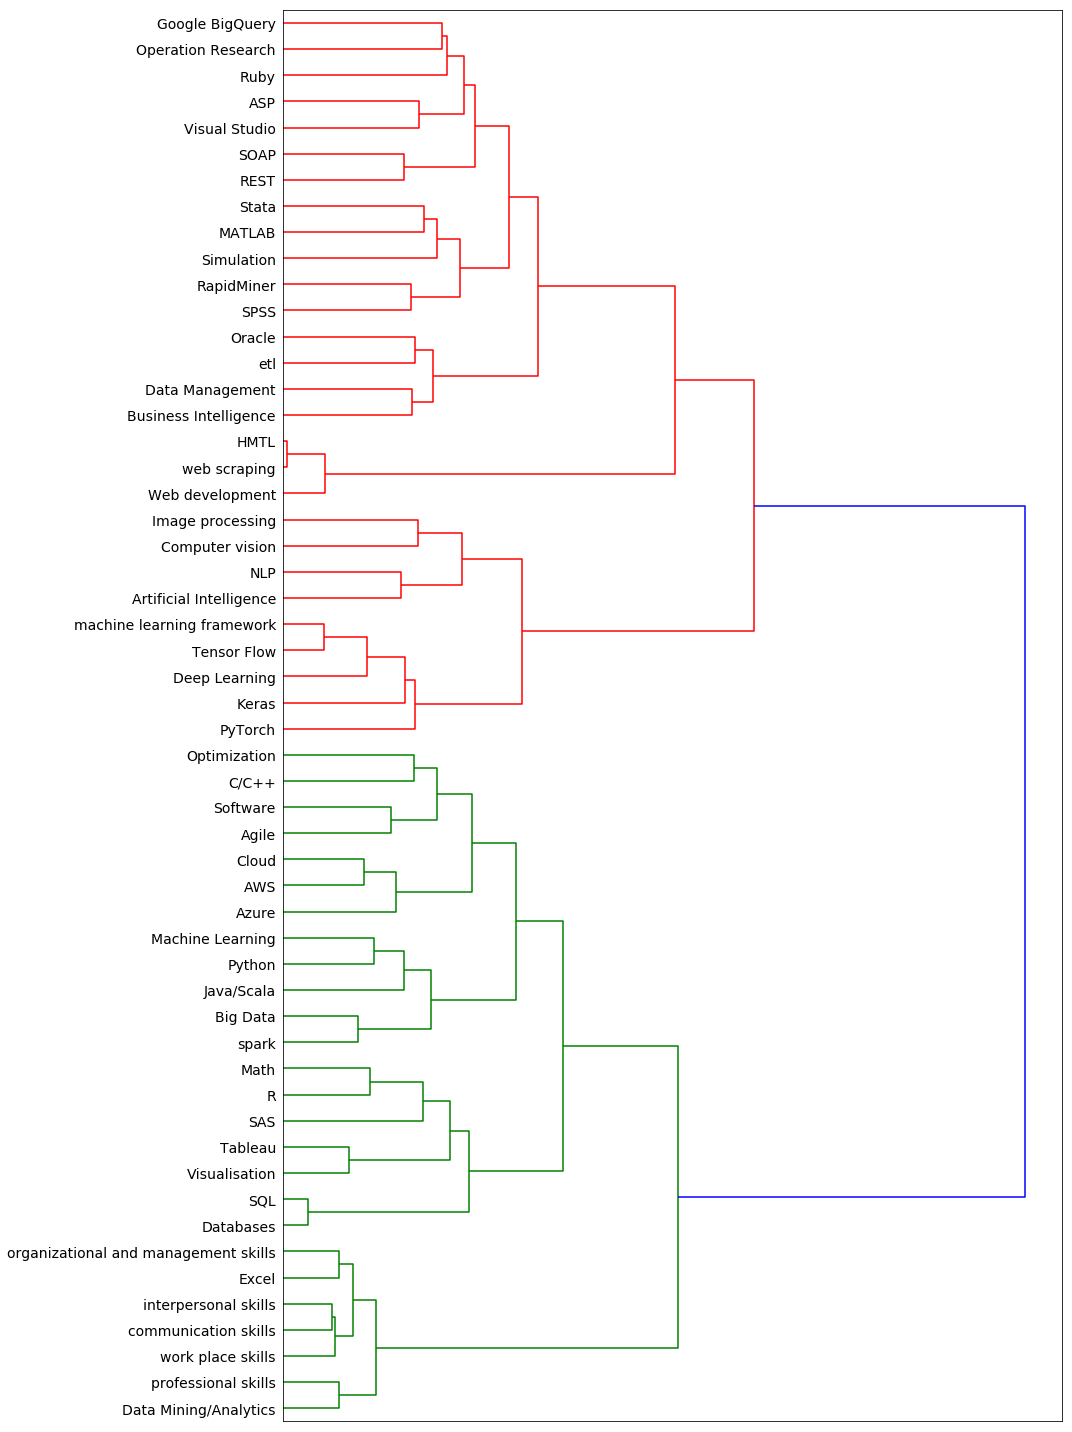

In [95]:
# Applying the defined fucntion to the dataframe and the dictionary 
Hierarchical_clustering(DS_skill_count_df,skills_keywords_dict,True)

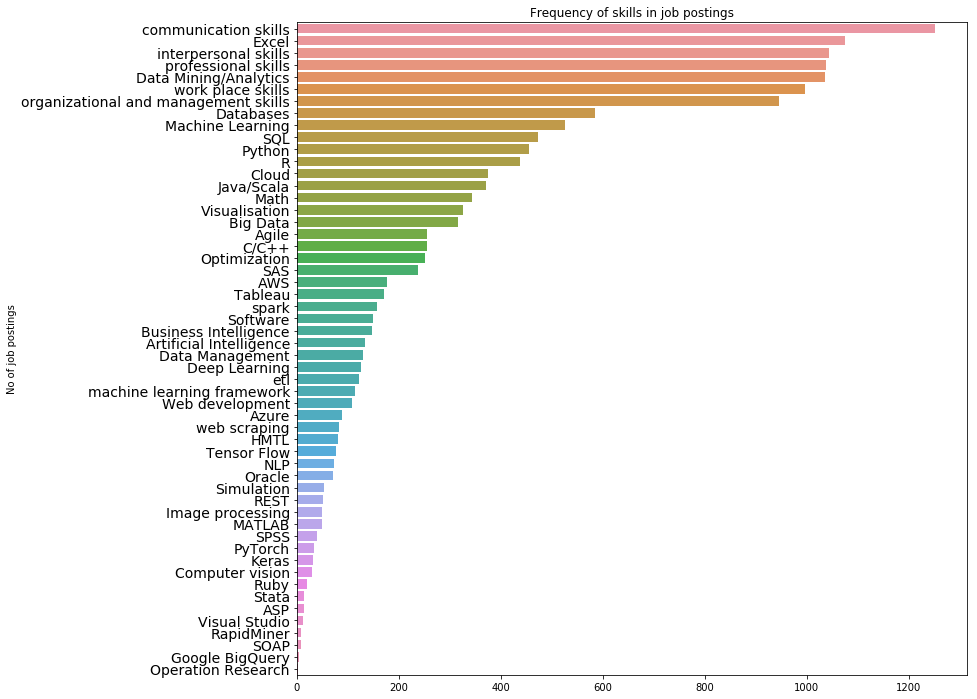

In [96]:
# Plotting the frequency of skills in job postings
plt.figure(figsize=(12,12))
sums_of_skills = DS_skill_count_df.iloc[:, 1:].sum().sort_values(ascending=False)
sns.barplot(y=sums_of_skills.index, x=sums_of_skills,orient ='h')
# Custoizing the tickmarks on y axis
plt.yticks(fontsize=14)
# Setting the plot y label
plt.ylabel("No of job postings")
# Setting the plot title
plt.title("Frequency of skills in job postings")
# Displaying the plot
plt.show()

In [97]:
skills_keywords_dict = {
                           
                            'Programming':[' R ','Python','Java', 'JVM', 'Scala', 'Javascript'],
                            'Databases/SQL': ['SQL', 'databases','NOSQL','Oracle'],
                            'Machine Learning': ['Machine Learning'],
                            'Artificial Intelligence':['artificial intelligence'],
                            'Optimization':['Optimization'],
                            'Simulation':['Simulation'],
                            'Project Management':['Project Management','Team work','Cooperation'],
                            'Data Visualisation': ['Visualisation', 'Visualization','Power Point', 'Tableau'],
                            'Software Development':['Software development','Agile'],
                            
                            'Software Development':['Software development'],
                            'Big Data': ['Big Data', 'Spark', 'kafka', 'Hive', 
                                         'beam', 'Hadoop', 'MapReduce', 'Hbase','MangoDB','Cassandra','Neo4','HDFS',
                                        'Google Cloud Dataproc',
                                        'Google Cloud Dataflow',
                                        'Google Cloud Dataprep',
                                        'AWS Kinesis',
                                        'Google Cloud Pub/Sub',
                                        'AWS Athena',
                                        'AWS Redshift',
                                        'Google BigQuery',
                                        'Teradata',
                                        'Microsoft Analysis Services',
                                        'Oracle Exadata',
                                        'Oracle Warehouse Builder',
                                        'SAP IQ',
                                        'Snowflake',
                                        'Databricks',
                                        'Azure SQL Data Warehouse',
                                        'Azure HDInsight',
                                        'Azure Stream Analytics',
                                        'IBM InfoSphere DataStorage',
                                        'IBM Cloud Analytics Engine',
                                        'IBM Cloud Streaming Analytics',
                                        ],
                            'Data Mining/Analytics': ['Data Mining',  'Data Analytics'],  
                            'Cloud': ['Cloud', 'AWS','EC2', 'GCP', 'Azure ', 'Google Cloud'
                                                        'Amazon Web Services',
                                                        'Microsoft Azure',
                                                        'IBM Cloud',
                                                        'Alibaba Cloud',
                                      
                                                        'Google Compute Engine',
                                                        'AWS Elastic Beanstalk',
                                                        'Google App Engine',
                                                        'Kubernete',
                                                        'Lambda',
                                                        'Google Cloud Functions',
                                                        'AWS Batch',
                                                        'Azure Virtual Machines',
                                                        'Azure Container Service',
                                                        'Azure Functions',
                                                        'Azure Event Grid',
                                                        'Azure Batch',
                                                        'Azure Kubernetes Service',
                                                        'IBM Cloud Virtual Servers',
                                                        'IBM Cloud Container Registry',
                                                        'IBM Cloud Kubernetes Service',
                                                        'IBM Cloud Foundry'
                                                        ],
                            'Deep Learning':['Deep learning', 'Tensor Flow','Caffe','Keras','Microsoft Cognitive Toolkit','IBM Watson','DeepLearning4J'],
                            }

In [98]:
DS_tech_prog_skill_count_df= skill_count(dfSkill_DS,skills_keywords_dict)
DS_tech_prog_skill_count_df.head()    

,cleaned_description,Programming,Databases/SQL,Machine Learning,Artificial Intelligence,Optimization,Simulation,Project Management,Data Visualisation,Software Development,Big Data,Data Mining/Analytics,Cloud,Deep Learning
0,montr al qccontractour telecom client is looki...,1,1,0,0,1,0,0,0,0,0,0,0,0
1,toronto oncontractdata scientist predictive mo...,1,1,1,0,0,0,0,1,0,1,1,0,0
2,toronto ondescription about the analytics insi...,1,1,1,0,0,0,0,1,0,1,1,1,0
3,tell us your story don t go unnoticed explain ...,0,0,0,0,0,0,0,0,0,0,0,0,0
4,toronto oninternshipgoogle sidewalk lab and pe...,1,1,1,0,0,0,0,1,0,1,0,0,1


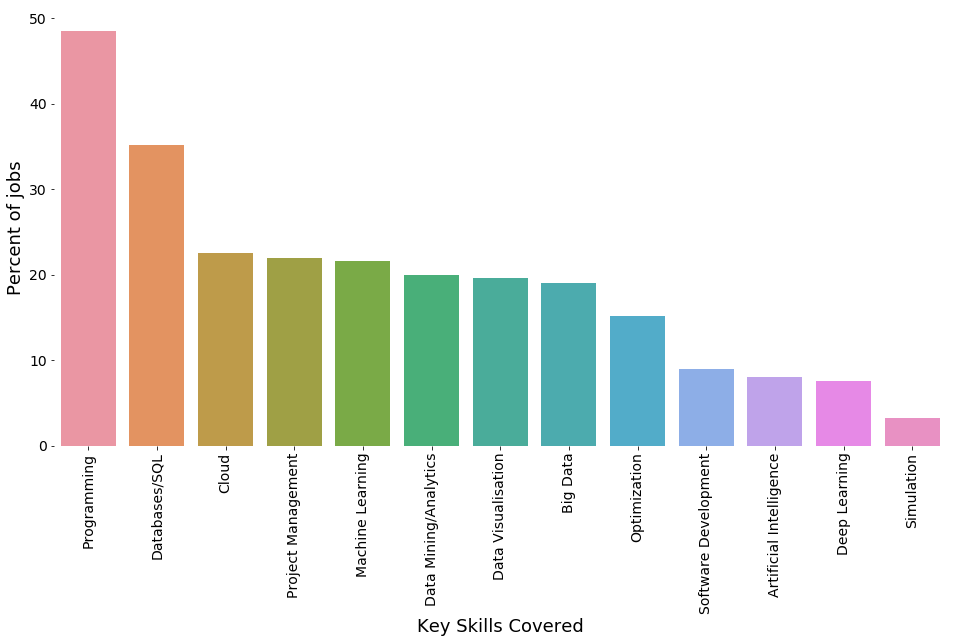

In [99]:
plt.figure(figsize=(16,8))
sums_of_skills = DS_tech_prog_skill_count_df.iloc[:, 1:].sum().sort_values(ascending=False)/len(DS_tech_prog_skill_count_df)*100
sns.barplot(x=sums_of_skills.index, y=sums_of_skills,orient ='v')
plt.xticks(fontsize=14,rotation =90)
plt.yticks(fontsize=14)

plt.xlabel("Key Skills Covered", fontsize=18)
plt.ylabel("Percent of jobs", fontsize=18)

# plt.title("Frequency of skills in job postings", fontsize=18, y=0.9,x=0.1)
plt.box(on=None)
plt.show()

# Insights from the developed hierarchy
Hereby, we discuss how we can make the most of the developed hierarchy. As for the green class of the skills in the developed hierarchy which includes a numerous number of skills, we decided to design different courses. This decision was based on the notion that it is impossible to include that many skills in a sole course.

## 1) Data Visualization and Communication
According to the graph, it represents the frequency of each skill in the job postings, we noticed that communication skills were on top the frequently-repeated skills. Therefore, designing a course to include these skills was necessary. To this end, the most important skills being covered in this course are visualization tools (Tableau/ggplot2/python libraries), and written/oral communication analytics. It makes sense if the ability to visualize has been considered an important part of successful communication, as the more visualized an output of a research/job, the more attractive it would be. This is basically due to the fact Tableau and visualization belong to the green class in the developed hierarchy.

## 2) Big Data and Cloud Computing:
As you can see in the graph above, the second most-frequently-occurred skill in the job postings was data mining and analytics. Please note that we have designed a workshop for those skills in between. Therefore, it was necessary to design a relevant course. The skills that are going to be covered in this course are Hadoop, spark, hive, AWS, Azure, python, and machine learning with big data. This is basically due to the fact that these skills have high frequencies/occurrences in the job postings. Furthermore, AWS, Azure, python, and machine learning are located on the green branch of the developed hierarchy which means they belong to one cluster, and the job postings need them together.

## 3) Deep Learning
Other class of important skills appearing on the graph above are those related to deep learning. As a result, we decided to design a related course. The most important skills which are going to be taught in this course are Natural language processing, image processing, neural network (CNN), Keras, and pytorch. These skills are basically appearing on the red branch of the developed hierarchy.

## 4) Applied Machine Learning
The rationale behind designing this course is that the term 'machine learning' has repeated frequently in the job postings. The most important techniques which are used in this course are linear algebra, feature selection, learning models, regression, classification, clustering, neural network, and python. These list of techniques has not appeared explicitly, as the term 'machine learning' is telling enough. Therefore, we identified the techniques based on what we have learned in the course and our innovation.

## 5) Statistics
Statistics is the underlying knowledge of every data science-based research. Therefore, we have started the master of data science program with this course. We selected the skills which are to be covered in this course based on our background statistical knowledge as well as what we have learned in the MIE1624 course.

## 6) Data Analytics
This course is again a sub-cluster of the green cluster of the hierarchy. The skills related to data analytics were selected to be taught in a course entitled 'data analytics'. These skills are SQL, web scraping, ETL, data cleaning, and data exploration. 

## 7) Capstone Project
The skills that are to be acquired rather than being taught, are included in a capstone project. These skills include team working, research design, reporting, documenting, and developing software.

## 8) Project Management Workshop
A number of project management skills, that students will learn better through workshops (i.e. meeting experts, sharing ideas with them, and exchanging knowledge) are to be covered in a project management workshop.

## 9) Software Development
The skills covered in this elective course are agile tools, software design, implementation and testing models, and deployment and maintenance of databases. These skills are another sub-cluster of the green cluster of skills.

## 10) Advanced Machine Learning and Artificial Intelligence
The skills which will be covered in this course are reinforcement skills, neural network, tensor flow, ensemble methods, and intelligent analytics. These advanced techniques were less frequent in the job postings, but they are important, therefore we have decided to consider this course as an elective course for students who are looking for advanced and high-profile education. 

## 11) Optimization and Simulation
The skills covered in this course are convex optimization, stochastic optimization, Monte-Carlo and other simulation methods, and optimization. A justification similar to that of course No. 10 can be provided to the selection of the skills.

# Extra Analysis from Kaggle dataset

In [100]:
# reading the kaggle_salary database into a dataframe
salaries_df = pd.read_csv('kaggle_salary.csv', index_col=0, skiprows=[1], low_memory=False)
salaries_df.head()

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT,index
2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0.0
3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.0
5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,I am a student,...,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,2.0
7,959,Male,-1,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,1,Academics/Education,...,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,-1,3.0
8,1758,Male,-1,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,2,Other,...,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,4.0


In [101]:
# Data Prep

# Pull just IDE Questions
ide_qs = salaries_df[['Q13_Part_1','Q13_Part_2','Q13_Part_3','Q13_Part_4','Q13_Part_5',
             'Q13_Part_6','Q13_Part_7','Q13_Part_8','Q13_Part_9','Q13_Part_10',
             'Q13_Part_11','Q13_Part_12','Q13_Part_13','Q13_Part_14','Q13_Part_15']]


# Rename Columns for IDE Type
column_rename = {'Q13_Part_1': 'Jupyter/IPython',
                 'Q13_Part_2': 'RStudio',
                'Q13_Part_3': 'PyCharm',
                'Q13_Part_4': 'Visual Studio Code',
                'Q13_Part_5': 'nteract',
                'Q13_Part_6': 'Atom',
                'Q13_Part_7': 'MATLAB',
                'Q13_Part_8': 'Visual Studio',
                'Q13_Part_9': 'Notepad++',
                'Q13_Part_10': 'Sublime Text',
                'Q13_Part_11': 'Vim',
                'Q13_Part_12': 'IntelliJ',
                'Q13_Part_13': 'Spyder',
                'Q13_Part_14': 'None',
                'Q13_Part_15': 'Other',
                }

# Make binary columns from IDE answers.
ide_qs_binary = ide_qs.rename(columns=column_rename).fillna(0).replace('[^\\d]',1, regex=True)

In [102]:
dfSkill = pd.read_csv('Job_Skills_DS_Cleaned.csv')

In [103]:
CodingLanguages_dict={
                        
                            'Python': ['Python'],
                            'R': [' R '], # 'R' surrounded by spaces and signs
                            'Ruby': ['Ruby'],
                            'Java/Scala': ['Java', 'JVM', 'Scala', 'Javascript'],
                            'C/C++': ['C/C++', 'C++', ' C '],   # 'C' surrounded by spaces and signs
                            'MATLAB': ['MATLAB'],
#                             'Visual Studio':['Visual Studio'],
                            'SAS': ['SAS'],
#                             'Databases': ['SQL', 'databases','NOSQL','Oracle'],
                            'SQL':['SQL'],
                            'Visual Basic':['Visual Basic'],
                            'html':['html'],
                   }

In [104]:
skill_count_df= skill_count(dfSkill,CodingLanguages_dict)
skill_count_df=skill_count_df.drop('cleaned_description', axis=1)
skill_count_df.head()

,Python,R,Ruby,Java/Scala,C/C++,MATLAB,SAS,SQL,Visual Basic,html
0,1,1,0,0,0,0,1,1,0,0
1,1,1,0,0,0,0,1,1,0,0
2,1,0,0,1,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0


In [105]:
ide_qs_binary = skill_count_df
total = len(ide_qs_binary)

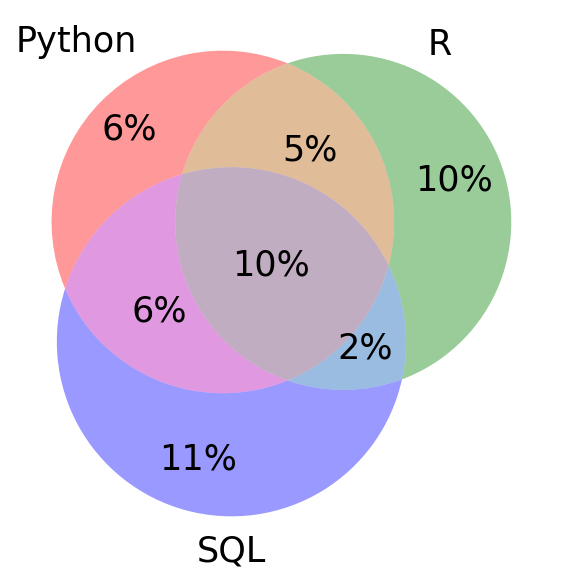

In [106]:
from matplotlib_venn import venn3

plt.figure(figsize=(15, 8))

out = venn3(subsets=(len(ide_qs_binary.loc[(ide_qs_binary['Python'] == 1) & (ide_qs_binary['R'] == 0) & (ide_qs_binary['SQL'] == 0)]),
               len(ide_qs_binary.loc[(ide_qs_binary['Python'] == 0) & (ide_qs_binary['R'] == 1) & (ide_qs_binary['SQL'] == 0)]),
               len(ide_qs_binary.loc[(ide_qs_binary['Python'] == 1) & (ide_qs_binary['R'] == 1) & (ide_qs_binary['SQL'] == 0)]),
               len(ide_qs_binary.loc[(ide_qs_binary['Python'] == 0) & (ide_qs_binary['R'] == 0) & (ide_qs_binary['SQL'] == 1)]),
               len(ide_qs_binary.loc[(ide_qs_binary['Python'] == 1) & (ide_qs_binary['R'] == 0) & (ide_qs_binary['SQL'] == 1)]),
               len(ide_qs_binary.loc[(ide_qs_binary['Python'] == 0) & (ide_qs_binary['R'] == 1) & (ide_qs_binary['SQL'] == 1)]),
               len(ide_qs_binary.loc[(ide_qs_binary['Python'] == 1) & (ide_qs_binary['R'] == 1) & (ide_qs_binary['SQL'] == 1)])),
      set_labels=('Python', 'R', 'SQL'),subset_label_formatter=lambda x: f"{(x/total):1.0%}")
for text in out.set_labels:
    text.set_fontsize(35)
for text in out.subset_labels:
    text.set_fontsize(35)
# plt.title('Jupyter vs RStudio vs SQL (All users)')
plt.tight_layout()
plt.show()

### Distribution of business-oriented jobs in the market based on the Kaggle survey
Based on the output of this analysis, we found that there are four major streams of business jobs: Finance, Internet based businesses, insurance, and marketing. Therefore, in our Master of business data analytics and AI, we have four comprehensive courses on these four major streams, as follows:
- **Financial Analytics**
- **Online Business Analytics**
- **Insurance Risk Analytics**
- **Marketing Analytics**

In these courses, the students will learn the state of the art machine learning and AI tools to use for the different problems in the business world.

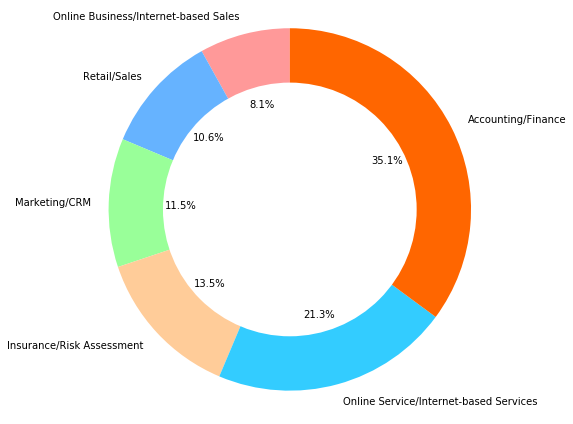

In [107]:
# Pie chart
labels = ['Online Business/Internet-based Sales','Retail/Sales','Marketing/CRM','Insurance/Risk Assessment','Online Service/Internet-based Services','Accounting/Finance']
sizes = [0.08085612366230678, 0.10582639714625446, 0.11474435196195006, 0.13495838287752676, 0.21254458977407847, 0.3510701545778835]
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#33ccff', '#ff6600']
fig1, ax1 = plt.subplots(figsize=(6.5, 6))
ax1.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()

### Importance of cloud
Based on the job postings and the salary survey, knowing about the cloud computing tools have a significant effect on the salary and the chance of getting a job. Hence, in both of our programs we have desined courses to teach students how to use data analytics in the cloud.

In [108]:
df = salaries_df
df['Q9'] = pd.to_numeric(df['Q9'], downcast='float')

In [109]:
df.groupby('Q12_MULTIPLE_CHOICE')['Q9'].mean()

Q12_MULTIPLE_CHOICE
Advanced statistical software (SPSS, SAS, etc.)                         57373.027344
Basic statistical software (Microsoft Excel, Google Sheets, etc.)       39629.230469
Business intelligence software (Salesforce, Tableau, Spotfire, etc.)    59358.304688
Cloud-based data software & APIs (AWS, GCP, Azure, etc.)                73993.648438
Local or hosted development environments (RStudio, JupyterLab, etc.)    51297.609375
Other                                                                   51536.394531
Name: Q9, dtype: float32

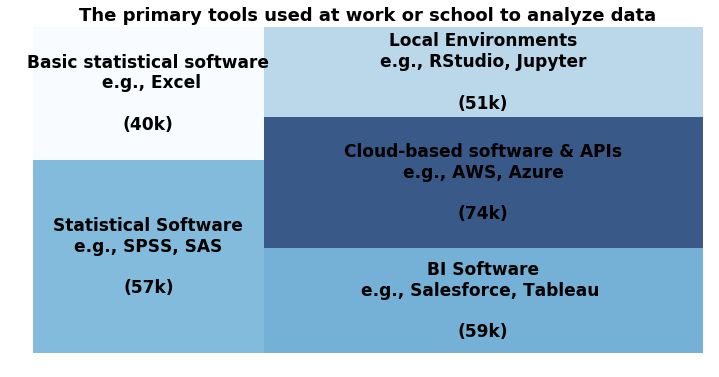

In [110]:
# libraries
import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)
import matplotlib
# If you have 2 lists
# squarify.plot(sizes=[13,22,35,5], label=["group A", "group B", "group C", "group D"], alpha=.7 )
# plt.axis('off')
# plt.show()
 
# If you have a data frame?
import pandas as pd
f, ax= plt.subplots(figsize=(12,6))
df1 = pd.DataFrame({'Count' : df.groupby('Q12_MULTIPLE_CHOICE')['Q9'].mean(), 'Tool': ['Statistical Software\ne.g., SPSS, SAS\n\n(57k)', 'Basic statistical software\n e.g., Excel\n\n(40k)', 'BI Software\ne.g., Salesforce, Tableau \n\n(59k)', 'Cloud-based software & APIs\ne.g., AWS, Azure\n\n(74k)', 'Local Environments\ne.g., RStudio, Jupyter\n\n(51k)', 'Other']})
df1.drop(df1[df1.Tool=='Other'].index, axis=0, inplace=True)
# df = pd.DataFrame({'nb_people':[8,3,4,2], 'group':["group A", "group B", "group C", "group D"] })
norm = matplotlib.colors.Normalize(vmin=min(df1.Count), vmax=max(df1.Count))
colors = [plt.cm.Blues(norm(value)) for value in df1.Count]

squarify.plot(sizes=df1.Count, label=df1['Tool'], color=colors, alpha=.8, text_kwargs={'fontsize':17, 'fontweight':"bold"})
#  color=["red","blue", "yellow","green", "orange"]
plt.axis('off')
plt.title("The primary tools used at work or school to analyze data",fontsize=18,fontweight="bold")
plt.savefig('Treemap.jpg', dpi=300, transparent=True , bbox_inches='tight')
plt.show()


### Importance of programming language based on salary and job postings
Based on the number of job postings which need the knowledge of a programming language, and the mean salary of those who know and use them, we decided to cover what programming languages in each of our programs, as well as our introductory course.

In [111]:
df1= pd.DataFrame({'Count' : df.groupby('Q17').size(), 'Salary': df.groupby('Q17')['Q9'].mean()/1000}).reset_index()
df1.sort_values(by=['Salary'], ascending = False)
df1

,Q17,Count,Salary
0,Bash,45,63.031845
1,C#/.NET,329,52.075607
2,C/C++,464,41.725414
3,Go,35,74.751945
4,Java,623,49.661724
5,Javascript/Typescript,308,45.136837
6,Julia,7,50.711143
7,MATLAB,247,39.575336
8,Other,93,67.556862
9,PHP,149,35.044342


In [112]:
df1.drop(df1[df1.Q17=='C#/.NET'].index, axis=0, inplace=True)
df1.drop(df1[df1.Q17=='Go'].index, axis=0, inplace=True)
df1.drop(df1[df1.Q17=='Julia'].index, axis=0, inplace=True)
df1.drop(df1[df1.Q17=='Visual Basic/VBA'].index, axis=0, inplace=True)
df1.drop(df1[df1.Q17=='PHP'].index, axis=0, inplace=True)
df1.drop(df1[df1.Q17=='Javascript/Typescript'].index, axis=0, inplace=True)
df1.drop(df1[df1.Q17=='Other'].index, axis=0, inplace=True)
df1.reset_index(drop=True, inplace=True)
df1

,Q17,Count,Salary
0,Bash,45,63.031845
1,C/C++,464,41.725414
2,Java,623,49.661724
3,MATLAB,247,39.575336
4,Python,5866,51.137966
5,R,1526,59.511425
6,Ruby,42,64.317215
7,SAS/STATA,179,69.362114
8,SQL,999,63.817730
9,Scala,81,78.281891


In [113]:
CodingLanguages_dict={
                            'Bash': ['Bash'],
                            'C/C++': ['C/C++', 'C++', ' C '],   # 'C' surrounded by spaces and signs
                            'Java': [' Java ', ' JVM '],
                            'MATLAB': ['MATLAB'],
                            'Python': ['Python'],
                            'R': [' R '], # 'R' surrounded by spaces and signs
                            'Ruby': ['Ruby'],
                            'SAS/STATA': ['SAS', 'Stata'],
                            'SQL':['SQL'],
                            'Scala': ['Scala'],
                   }

In [114]:
skill_count_df= skill_count(dfSkill,CodingLanguages_dict)
skill_count_df=skill_count_df.drop('cleaned_description', axis=1)
skill_count_df.head()

,Bash,C/C++,Java,MATLAB,Python,R,Ruby,SAS/STATA,SQL,Scala
0,0,0,0,0,1,1,0,1,1,0
1,0,0,0,0,1,1,0,1,1,0
2,0,0,1,0,1,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,1,0


In [115]:
df1.Count = skill_count_df.sum().values*10
df1

,Q17,Count,Salary
0,Bash,250,63.031845
1,C/C++,2560,41.725414
2,Java,1530,49.661724
3,MATLAB,490,39.575336
4,Python,4550,51.137966
5,R,4380,59.511425
6,Ruby,190,64.317215
7,SAS/STATA,2410,69.362114
8,SQL,4730,63.817730
9,Scala,2400,78.281891


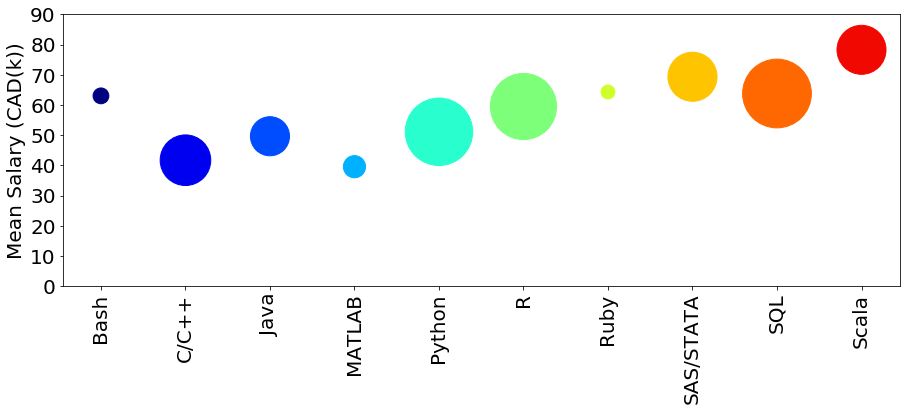

In [116]:
# doubling the area of markers
f, ax= plt.subplots(figsize=(15,5))
x = df1.Q17
y = df1.Salary
s = df1.Count
plt.scatter(x,y,s=s, color = [cm.jet(1.*e/len(x)) for e in range(len(x))])
plt.xticks(rotation = 90, fontsize= 20)
plt.yticks(fontsize= 20)
plt.ylabel('Mean Salary (CAD(k))', fontsize= 20)
plt.ylim(0, 90)
plt.savefig('Scatter.png', dpi=300, transparent=True , bbox_inches='tight')
#plt.grid(b=None)
#plt.box(on=None)
plt.show()

The size of each point represents the frequency of the corresponding programming language in the job postings at the indeed webpage.